# N:2 MENT — sample-based solver

In [1]:
import os
import sys
import time

import numpy as np
import psdist as ps
import psdist.plot as psv
import ultraplot as plt
from ipywidgets import interact
from tqdm.notebook import tqdm
from tqdm.notebook import trange

import ment
from ment.sim import simulate
from ment.train.plot import PlotDistCorner
from ment.train.plot import PlotProj2D_Contour
from ment.utils import unravel

In [2]:
plt.rc["cmap.discrete"] = False
plt.rc["cmap.sequential"] = "viridis"
plt.rc["figure.facecolor"] = "white"
plt.rc["grid"] = False

## Source distribution

In [3]:
dist_name = "gaussian_mixture"
ndim = 6
xmax = 3.5
seed = 12345

In [4]:
dist = ment.dist.get_dist(dist_name, ndim=ndim, seed=seed)
x_true = dist.sample(1_000_000)

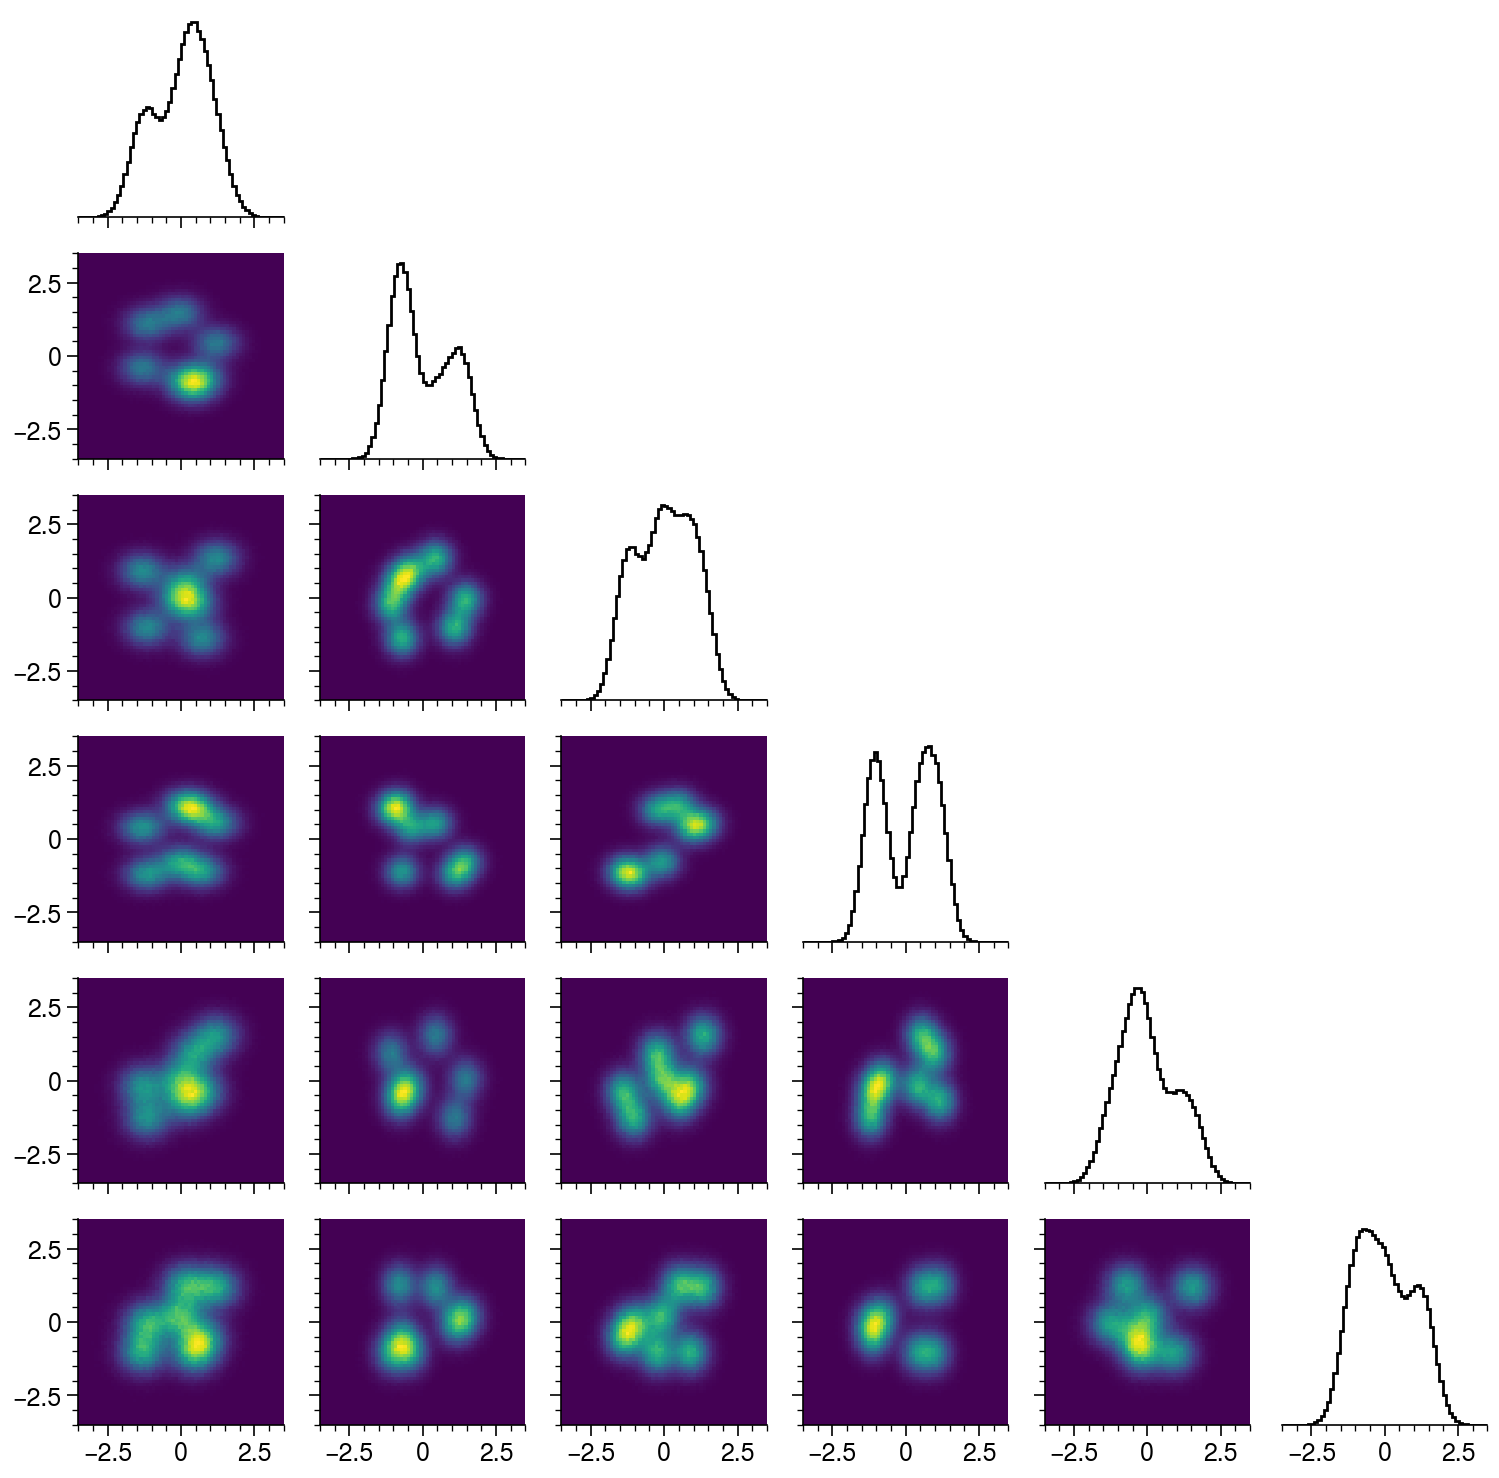

In [5]:
limits = ndim * [(-xmax, xmax)]

grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.25))
grid.plot_points(x_true, limits=limits, bins=64, mask=False)
plt.show()

## Data generation

In [6]:
nmeas = ndim * (ndim - 1) // 2
nbins = 64
blur = 0.0
kde = False
kde_bandwidth_frac = 1.0
axis_meas = (0, 2)

In [7]:
# Create transforms (permutation matrices)
transfer_matrices = []
for i in range(ndim):
    for j in range(i):
        matrices = []
        for k, l in zip(axis_meas, (j, i)):
            matrix = np.identity(ndim)
            matrix[k, k] = matrix[l, l] = 0.0
            matrix[k, l] = matrix[l, k] = 1.0
            matrices.append(matrix)
        transfer_matrices.append(np.linalg.multi_dot(matrices[::-1]))

transforms = []
for matrix in transfer_matrices:
    transform = ment.sim.LinearTransform(matrix)
    transforms.append(transform)

# Create histogram diagnostics
axis_proj = axis_meas
bin_edges = 2 * [np.linspace(-xmax, xmax, nbins + 1)]

projections = []
for transform in transforms:
    projection = ment.diag.HistogramND(
        axis=axis_meas,
        edges=bin_edges,
        kde=kde,
        kde_bandwidth_frac=kde_bandwidth_frac,
        blur=blur,
        thresh=0.0,
        thresh_type="abs",
    )
    projections.append([projection])

# Generate data
projections = ment.sim.simulate_with_diag_update(
    x_true,
    transforms,
    projections,
    kde=False,
    blur=False,
    thresh=5.00e-03,
)

In [8]:
# @interact(index=(0, nmeas - 1))
# def update(index: int):
#     coords = unravel(projections)[index].coords
#     values = unravel(projections)[index].values

#     fig, ax = plt.subplots()
#     ax.pcolormesh(coords[0], coords[1], values.T, colorbar=True,)

## Model

In [9]:
sampler = "mcmc"
nsamp = 1_000_000
burnin = 500
chains = 1000
c = 2.4 / np.sqrt(ndim)

if sampler == "grid":
    samp_grid_res = 32
    samp_noise = 0.5
    samp_grid_shape = ndim * [samp_grid_res]
    samp_grid_limits = limits

    sampler = ment.samp.GridSampler(
        grid_limits=samp_grid_limits,
        grid_shape=samp_grid_shape,
        noise=samp_noise,
    )
elif sampler == "mcmc":
    proposal_cov = 0.1 * np.eye(ndim)

    start = np.random.multivariate_normal(np.zeros(ndim), 0.5 * np.eye(ndim), size=chains)

    sampler = ment.samp.MetropolisHastingsSampler(
        ndim=ndim,
        chains=chains,
        proposal_cov=proposal_cov,
        start=start,
        burnin=burnin,
        shuffle=True,
        verbose=True,
    )
else:
    raise ValueError

In [10]:
prior = ment.GaussianPrior(ndim=ndim, scale=1.0)

model = ment.MENT(
    ndim=ndim,
    transforms=transforms,
    projections=projections,
    prior=prior,
    interpolation_kws=dict(method="linear"),
    sampler=sampler,
    nsamp=nsamp,
    mode="sample",
    verbose=0,
)

## Training

In [11]:
plot_nsamp = 1_000_000

In [12]:
def plot_model(model):
    figs = []

    # Sample particles
    x_pred = model.sample(plot_nsamp)

    # Plot reconstructed vs. true distribution
    grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.25), diag_shrink=0.80)
    grid.plot_points(
        x_pred,
        limits=limits,
        bins=65,
        mask=False,
        cmap="viridis",
    )
    figs.append(grid.fig)

    # Simulate measurements
    projections_true = ment.sim.copy_histograms(model.projections)
    projections_pred = ment.sim.copy_histograms(model.diagnostics)
    projections_pred = ment.sim.simulate_with_diag_update(
        x_pred, transforms, projections_pred, kde=False, blur=False
    )

    projections_true = unravel(projections_true)
    projections_pred = unravel(projections_pred)

    # Plot simulated vs. measured projections.
    contour_levels = np.linspace(0.01, 1.0, 7)
    contour_colors = ["black", "red"]
    plot_kws = dict(
        process_kws=dict(blur=1.0, scale="max"),
        kind="contour",
        levels=contour_levels,
        lw=0.9,
    )

    ncols = min(nmeas, 7)
    nrows = int(np.ceil(nmeas / ncols))
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figwidth=(1.1 * ncols))
    for proj_true, proj_pred, ax in zip(projections_true, projections_pred, axs):
        psv.plot_hist(proj_true, ax=ax, colors=contour_colors[0], **plot_kws)
        psv.plot_hist(proj_pred, ax=ax, colors=contour_colors[1], **plot_kws)
    figs.append(fig)

    return figs

non numeric history values being saved


  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▉                                                                                                                                                           | 64/1499 [00:00<00:02, 635.79it/s]

  9%|█████████████▊                                                                                                                                                   | 129/1499 [00:00<00:02, 643.97it/s]

 13%|█████████████████████                                                                                                                                            | 196/1499 [00:00<00:01, 654.54it/s]

 17%|████████████████████████████▏                                                                                                                                    | 262/1499 [00:00<00:01, 650.92it/s]

 22%|███████████████████████████████████▏                                                                                                                             | 328/1499 [00:00<00:01, 649.66it/s]

 26%|██████████████████████████████████████████▍                                                                                                                      | 395/1499 [00:00<00:01, 653.48it/s]

 31%|█████████████████████████████████████████████████▌                                                                                                               | 461/1499 [00:00<00:01, 654.98it/s]

 35%|████████████████████████████████████████████████████████▋                                                                                                        | 528/1499 [00:00<00:01, 658.21it/s]

 40%|████████████████████████████████████████████████████████████████                                                                                                 | 596/1499 [00:00<00:01, 662.88it/s]

 44%|███████████████████████████████████████████████████████████████████████▏                                                                                         | 663/1499 [00:01<00:01, 661.31it/s]

 49%|██████████████████████████████████████████████████████████████████████████████▍                                                                                  | 730/1499 [00:01<00:01, 661.09it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 797/1499 [00:01<00:01, 660.68it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 865/1499 [00:01<00:00, 663.73it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 932/1499 [00:01<00:00, 663.95it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 999/1499 [00:01<00:00, 664.29it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1066/1499 [00:01<00:00, 664.56it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1133/1499 [00:01<00:00, 665.58it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1200/1499 [00:01<00:00, 666.33it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1267/1499 [00:01<00:00, 667.03it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1334/1499 [00:02<00:00, 667.70it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1401/1499 [00:02<00:00, 668.05it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1468/1499 [00:02<00:00, 668.04it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 661.61it/s]

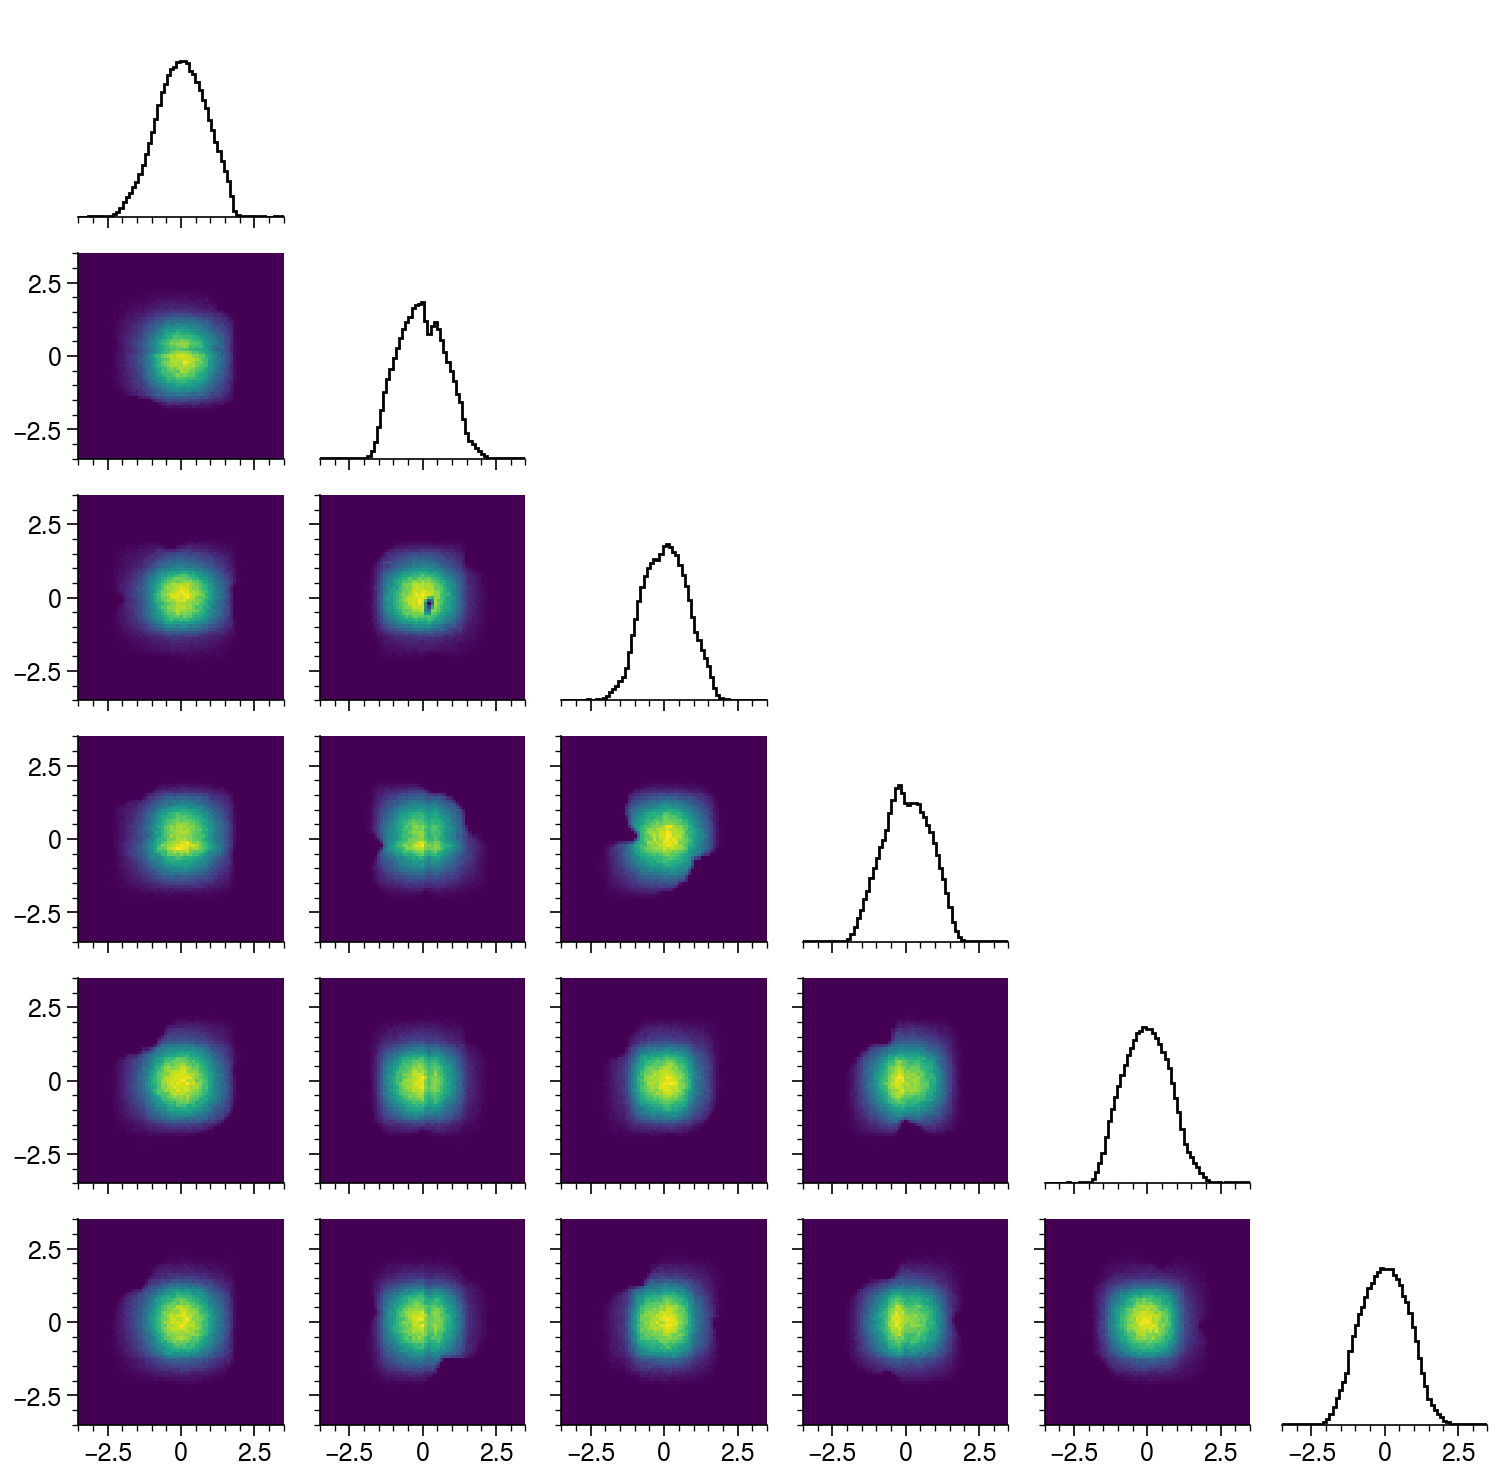

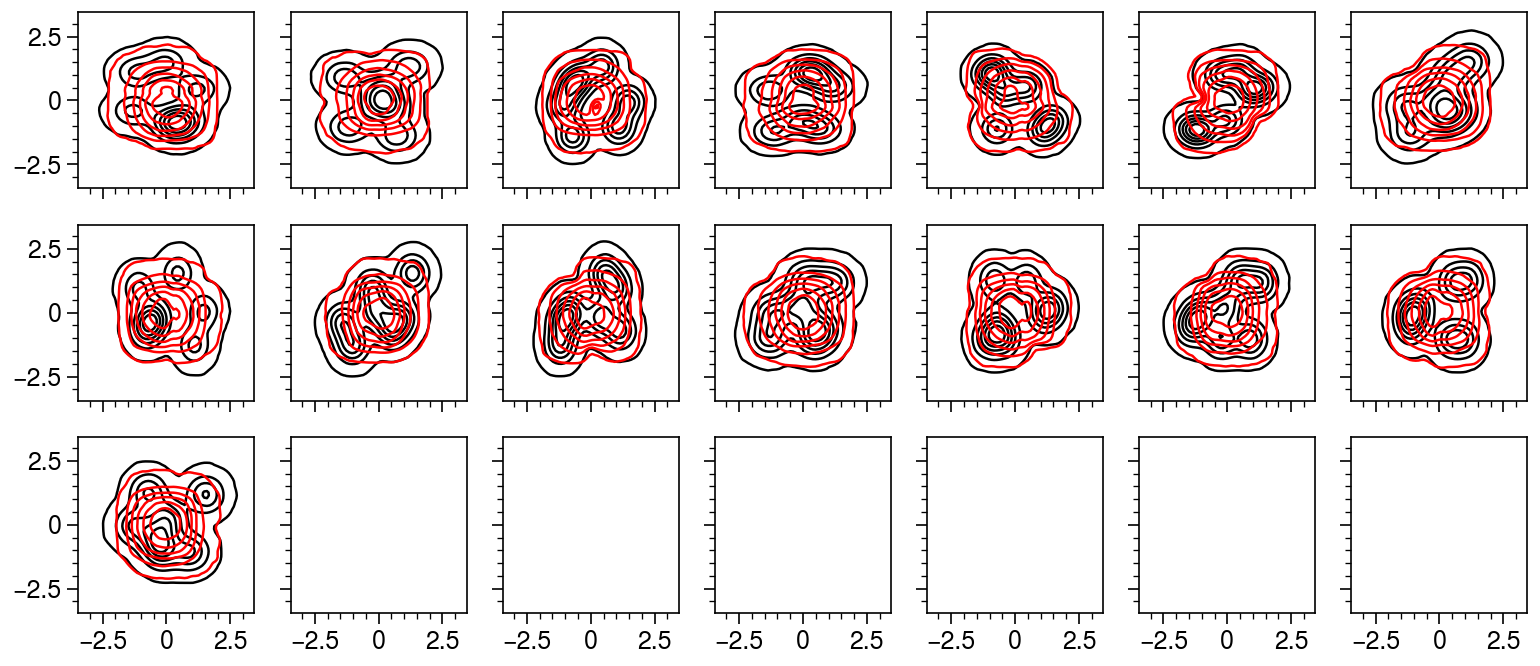

None
epoch = 1


  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▊                                                                                                                                                           | 63/1499 [00:00<00:02, 628.17it/s]

  8%|█████████████▌                                                                                                                                                   | 126/1499 [00:00<00:02, 614.65it/s]

 13%|████████████████████▏                                                                                                                                            | 188/1499 [00:00<00:02, 616.77it/s]

 17%|███████████████████████████                                                                                                                                      | 252/1499 [00:00<00:01, 625.80it/s]

 21%|██████████████████████████████████                                                                                                                               | 317/1499 [00:00<00:01, 633.44it/s]

 26%|█████████████████████████████████████████▏                                                                                                                       | 383/1499 [00:00<00:01, 639.90it/s]

 30%|████████████████████████████████████████████████▎                                                                                                                | 450/1499 [00:00<00:01, 647.17it/s]

 34%|███████████████████████████████████████████████████████▎                                                                                                         | 515/1499 [00:00<00:01, 642.21it/s]

 39%|██████████████████████████████████████████████████████████████▎                                                                                                  | 580/1499 [00:00<00:01, 638.73it/s]

 43%|█████████████████████████████████████████████████████████████████████▏                                                                                           | 644/1499 [00:01<00:01, 629.21it/s]

 47%|███████████████████████████████████████████████████████████████████████████▉                                                                                     | 707/1499 [00:01<00:01, 619.45it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▉                                                                              | 772/1499 [00:01<00:01, 626.06it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 836/1499 [00:01<00:01, 627.80it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 904/1499 [00:01<00:00, 640.65it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 972/1499 [00:01<00:00, 650.59it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1039/1499 [00:01<00:00, 656.07it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1105/1499 [00:01<00:00, 656.20it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1172/1499 [00:01<00:00, 658.39it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1240/1499 [00:01<00:00, 663.21it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1308/1499 [00:02<00:00, 666.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1376/1499 [00:02<00:00, 669.98it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1444/1499 [00:02<00:00, 667.87it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 646.85it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|███████                                                                                                                                                           | 65/1499 [00:00<00:02, 648.85it/s]

  9%|█████████████▉                                                                                                                                                   | 130/1499 [00:00<00:02, 647.68it/s]

 13%|█████████████████████                                                                                                                                            | 196/1499 [00:00<00:02, 648.62it/s]

 17%|████████████████████████████                                                                                                                                     | 261/1499 [00:00<00:01, 647.89it/s]

 22%|███████████████████████████████████                                                                                                                              | 326/1499 [00:00<00:01, 642.87it/s]

 26%|█████████████████████████████████████████▉                                                                                                                       | 391/1499 [00:00<00:01, 637.73it/s]

 30%|█████████████████████████████████████████████████                                                                                                                | 457/1499 [00:00<00:01, 642.59it/s]

 35%|████████████████████████████████████████████████████████                                                                                                         | 522/1499 [00:00<00:01, 639.51it/s]

 39%|██████████████████████████████████████████████████████████████▉                                                                                                  | 586/1499 [00:00<00:01, 637.63it/s]

 43%|██████████████████████████████████████████████████████████████████████                                                                                           | 652/1499 [00:01<00:01, 642.24it/s]

 48%|█████████████████████████████████████████████████████████████████████████████                                                                                    | 717/1499 [00:01<00:01, 639.10it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████                                                                             | 783/1499 [00:01<00:01, 643.17it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 849/1499 [00:01<00:01, 646.58it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 915/1499 [00:01<00:00, 648.38it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 980/1499 [00:01<00:00, 647.12it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1045/1499 [00:01<00:00, 647.50it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 1111/1499 [00:01<00:00, 650.43it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1177/1499 [00:01<00:00, 646.02it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 1242/1499 [00:01<00:00, 645.85it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1308/1499 [00:02<00:00, 648.02it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1374/1499 [00:02<00:00, 650.34it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1440/1499 [00:02<00:00, 652.95it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 646.27it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|███████                                                                                                                                                           | 65/1499 [00:00<00:02, 643.13it/s]

  9%|█████████████▉                                                                                                                                                   | 130/1499 [00:00<00:02, 643.21it/s]

 13%|█████████████████████                                                                                                                                            | 196/1499 [00:00<00:02, 647.23it/s]

 18%|████████████████████████████▏                                                                                                                                    | 263/1499 [00:00<00:01, 653.44it/s]

 22%|███████████████████████████████████▎                                                                                                                             | 329/1499 [00:00<00:01, 654.61it/s]

 26%|██████████████████████████████████████████▍                                                                                                                      | 395/1499 [00:00<00:01, 655.98it/s]

 31%|█████████████████████████████████████████████████▌                                                                                                               | 461/1499 [00:00<00:01, 656.45it/s]

 35%|████████████████████████████████████████████████████████▌                                                                                                        | 527/1499 [00:00<00:01, 653.51it/s]

 40%|███████████████████████████████████████████████████████████████▋                                                                                                 | 593/1499 [00:00<00:01, 651.35it/s]

 44%|██████████████████████████████████████████████████████████████████████▊                                                                                          | 659/1499 [00:01<00:01, 649.06it/s]

 48%|█████████████████████████████████████████████████████████████████████████████▊                                                                                   | 725/1499 [00:01<00:01, 650.08it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 791/1499 [00:01<00:01, 648.04it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 857/1499 [00:01<00:00, 650.05it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 923/1499 [00:01<00:00, 650.24it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 989/1499 [00:01<00:00, 650.96it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1055/1499 [00:01<00:00, 653.38it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1121/1499 [00:01<00:00, 648.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1188/1499 [00:01<00:00, 652.29it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1255/1499 [00:01<00:00, 654.97it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1322/1499 [00:02<00:00, 657.92it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1389/1499 [00:02<00:00, 659.79it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1455/1499 [00:02<00:00, 658.39it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 653.16it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▊                                                                                                                                                           | 63/1499 [00:00<00:02, 627.13it/s]

  9%|█████████████▊                                                                                                                                                   | 129/1499 [00:00<00:02, 642.12it/s]

 13%|████████████████████▉                                                                                                                                            | 195/1499 [00:00<00:02, 648.72it/s]

 17%|████████████████████████████                                                                                                                                     | 261/1499 [00:00<00:01, 652.60it/s]

 22%|███████████████████████████████████                                                                                                                              | 327/1499 [00:00<00:01, 650.65it/s]

 26%|██████████████████████████████████████████▏                                                                                                                      | 393/1499 [00:00<00:01, 648.55it/s]

 31%|█████████████████████████████████████████████████▎                                                                                                               | 459/1499 [00:00<00:01, 649.10it/s]

 35%|████████████████████████████████████████████████████████▎                                                                                                        | 524/1499 [00:00<00:01, 647.34it/s]

 39%|███████████████████████████████████████████████████████████████▎                                                                                                 | 590/1499 [00:00<00:01, 648.76it/s]

 44%|██████████████████████████████████████████████████████████████████████▎                                                                                          | 655/1499 [00:01<00:01, 647.31it/s]

 48%|█████████████████████████████████████████████████████████████████████████████▍                                                                                   | 721/1499 [00:01<00:01, 648.90it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 787/1499 [00:01<00:01, 650.24it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 853/1499 [00:01<00:00, 649.06it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 918/1499 [00:01<00:00, 648.57it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 985/1499 [00:01<00:00, 653.09it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1052/1499 [00:01<00:00, 656.79it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1119/1499 [00:01<00:00, 659.40it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1186/1499 [00:01<00:00, 659.43it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1252/1499 [00:01<00:00, 657.59it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1318/1499 [00:02<00:00, 656.12it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1384/1499 [00:02<00:00, 654.12it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1450/1499 [00:02<00:00, 654.72it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 651.31it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▉                                                                                                                                                           | 64/1499 [00:00<00:02, 632.79it/s]

  9%|█████████████▋                                                                                                                                                   | 128/1499 [00:00<00:02, 633.90it/s]

 13%|████████████████████▌                                                                                                                                            | 192/1499 [00:00<00:02, 634.43it/s]

 17%|███████████████████████████▍                                                                                                                                     | 256/1499 [00:00<00:01, 635.66it/s]

 21%|██████████████████████████████████▎                                                                                                                              | 320/1499 [00:00<00:01, 635.26it/s]

 26%|█████████████████████████████████████████▍                                                                                                                       | 386/1499 [00:00<00:01, 641.28it/s]

 30%|████████████████████████████████████████████████▍                                                                                                                | 451/1499 [00:00<00:01, 641.94it/s]

 34%|███████████████████████████████████████████████████████▍                                                                                                         | 516/1499 [00:00<00:01, 641.56it/s]

 39%|██████████████████████████████████████████████████████████████▍                                                                                                  | 581/1499 [00:00<00:01, 641.81it/s]

 43%|█████████████████████████████████████████████████████████████████████▍                                                                                           | 647/1499 [00:01<00:01, 644.49it/s]

 48%|████████████████████████████████████████████████████████████████████████████▌                                                                                    | 713/1499 [00:01<00:01, 646.46it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████▌                                                                             | 778/1499 [00:01<00:01, 645.33it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 843/1499 [00:01<00:01, 645.22it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 908/1499 [00:01<00:00, 644.66it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 974/1499 [00:01<00:00, 647.79it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1040/1499 [00:01<00:00, 648.86it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1106/1499 [00:01<00:00, 649.56it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1171/1499 [00:01<00:00, 642.90it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1236/1499 [00:01<00:00, 634.44it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1301/1499 [00:02<00:00, 637.15it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1366/1499 [00:02<00:00, 640.11it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1431/1499 [00:02<00:00, 641.31it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1497/1499 [00:02<00:00, 646.47it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 642.38it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|███████                                                                                                                                                           | 65/1499 [00:00<00:02, 640.50it/s]

  9%|██████████████▏                                                                                                                                                  | 132/1499 [00:00<00:02, 652.40it/s]

 13%|█████████████████████▎                                                                                                                                           | 198/1499 [00:00<00:01, 652.07it/s]

 18%|████████████████████████████▍                                                                                                                                    | 265/1499 [00:00<00:01, 655.17it/s]

 22%|███████████████████████████████████▌                                                                                                                             | 331/1499 [00:00<00:01, 655.27it/s]

 26%|██████████████████████████████████████████▋                                                                                                                      | 397/1499 [00:00<00:01, 653.93it/s]

 31%|█████████████████████████████████████████████████▋                                                                                                               | 463/1499 [00:00<00:01, 655.11it/s]

 35%|████████████████████████████████████████████████████████▊                                                                                                        | 529/1499 [00:00<00:01, 656.63it/s]

 40%|███████████████████████████████████████████████████████████████▉                                                                                                 | 595/1499 [00:00<00:01, 654.96it/s]

 44%|██████████████████████████████████████████████████████████████████████▉                                                                                          | 661/1499 [00:01<00:01, 655.51it/s]

 48%|██████████████████████████████████████████████████████████████████████████████                                                                                   | 727/1499 [00:01<00:01, 656.78it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 793/1499 [00:01<00:01, 657.15it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 859/1499 [00:01<00:00, 657.40it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 926/1499 [00:01<00:00, 660.26it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 993/1499 [00:01<00:00, 661.36it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1060/1499 [00:01<00:00, 660.14it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1127/1499 [00:01<00:00, 659.40it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1193/1499 [00:01<00:00, 659.30it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1260/1499 [00:01<00:00, 661.04it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1327/1499 [00:02<00:00, 659.84it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1394/1499 [00:02<00:00, 660.80it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1461/1499 [00:02<00:00, 662.62it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 658.40it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|███████                                                                                                                                                           | 65/1499 [00:00<00:02, 644.78it/s]

  9%|█████████████▉                                                                                                                                                   | 130/1499 [00:00<00:02, 646.81it/s]

 13%|█████████████████████                                                                                                                                            | 196/1499 [00:00<00:02, 649.42it/s]

 17%|████████████████████████████▏                                                                                                                                    | 262/1499 [00:00<00:01, 651.27it/s]

 22%|███████████████████████████████████▏                                                                                                                             | 328/1499 [00:00<00:01, 654.26it/s]

 26%|██████████████████████████████████████████▍                                                                                                                      | 395/1499 [00:00<00:01, 656.56it/s]

 31%|█████████████████████████████████████████████████▌                                                                                                               | 461/1499 [00:00<00:01, 655.46it/s]

 35%|████████████████████████████████████████████████████████▌                                                                                                        | 527/1499 [00:00<00:01, 654.60it/s]

 40%|███████████████████████████████████████████████████████████████▋                                                                                                 | 593/1499 [00:00<00:01, 655.54it/s]

 44%|██████████████████████████████████████████████████████████████████████▊                                                                                          | 659/1499 [00:01<00:01, 655.58it/s]

 48%|█████████████████████████████████████████████████████████████████████████████▊                                                                                   | 725/1499 [00:01<00:01, 654.36it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 791/1499 [00:01<00:01, 649.12it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 857/1499 [00:01<00:00, 651.72it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 924/1499 [00:01<00:00, 656.10it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 991/1499 [00:01<00:00, 658.23it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1057/1499 [00:01<00:00, 656.91it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1123/1499 [00:01<00:00, 656.04it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1189/1499 [00:01<00:00, 656.70it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1255/1499 [00:01<00:00, 656.89it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1321/1499 [00:02<00:00, 656.65it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1387/1499 [00:02<00:00, 656.57it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1453/1499 [00:02<00:00, 656.96it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 654.93it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|███████                                                                                                                                                           | 65/1499 [00:00<00:02, 649.42it/s]

  9%|█████████████▉                                                                                                                                                   | 130/1499 [00:00<00:02, 649.51it/s]

 13%|████████████████████▉                                                                                                                                            | 195/1499 [00:00<00:02, 648.77it/s]

 17%|████████████████████████████                                                                                                                                     | 261/1499 [00:00<00:01, 651.30it/s]

 22%|███████████████████████████████████                                                                                                                              | 327/1499 [00:00<00:01, 652.01it/s]

 26%|██████████████████████████████████████████▎                                                                                                                      | 394/1499 [00:00<00:01, 655.54it/s]

 31%|█████████████████████████████████████████████████▍                                                                                                               | 460/1499 [00:00<00:01, 655.14it/s]

 35%|████████████████████████████████████████████████████████▍                                                                                                        | 526/1499 [00:00<00:01, 650.80it/s]

 39%|███████████████████████████████████████████████████████████████▌                                                                                                 | 592/1499 [00:00<00:01, 650.03it/s]

 44%|██████████████████████████████████████████████████████████████████████▋                                                                                          | 658/1499 [00:01<00:01, 647.32it/s]

 48%|█████████████████████████████████████████████████████████████████████████████▋                                                                                   | 723/1499 [00:01<00:01, 647.59it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 788/1499 [00:01<00:01, 647.26it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 854/1499 [00:01<00:00, 649.00it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 919/1499 [00:01<00:00, 641.69it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 984/1499 [00:01<00:00, 637.74it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1048/1499 [00:01<00:00, 637.90it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 1113/1499 [00:01<00:00, 639.30it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1178/1499 [00:01<00:00, 641.52it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1243/1499 [00:01<00:00, 642.21it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1309/1499 [00:02<00:00, 645.48it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1375/1499 [00:02<00:00, 647.74it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1440/1499 [00:02<00:00, 646.94it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 646.17it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▋                                                                                                                                                           | 62/1499 [00:00<00:02, 617.67it/s]

  8%|█████████████▍                                                                                                                                                   | 125/1499 [00:00<00:02, 623.48it/s]

 13%|████████████████████▏                                                                                                                                            | 188/1499 [00:00<00:02, 625.97it/s]

 17%|███████████████████████████                                                                                                                                      | 252/1499 [00:00<00:01, 628.02it/s]

 21%|█████████████████████████████████▊                                                                                                                               | 315/1499 [00:00<00:01, 623.90it/s]

 25%|████████████████████████████████████████▋                                                                                                                        | 379/1499 [00:00<00:01, 625.92it/s]

 30%|███████████████████████████████████████████████▌                                                                                                                 | 443/1499 [00:00<00:01, 627.60it/s]

 34%|██████████████████████████████████████████████████████▍                                                                                                          | 507/1499 [00:00<00:01, 631.04it/s]

 38%|█████████████████████████████████████████████████████████████▎                                                                                                   | 571/1499 [00:00<00:01, 623.62it/s]

 42%|████████████████████████████████████████████████████████████████████                                                                                             | 634/1499 [00:01<00:01, 619.61it/s]

 46%|██████████████████████████████████████████████████████████████████████████▊                                                                                      | 697/1499 [00:01<00:01, 621.83it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████▊                                                                               | 762/1499 [00:01<00:01, 626.42it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 826/1499 [00:01<00:01, 630.47it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 890/1499 [00:01<00:00, 632.24it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 954/1499 [00:01<00:00, 625.45it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1017/1499 [00:01<00:00, 626.68it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 1081/1499 [00:01<00:00, 630.22it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1145/1499 [00:01<00:00, 632.50it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1211/1499 [00:01<00:00, 639.25it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1277/1499 [00:02<00:00, 644.46it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1342/1499 [00:02<00:00, 644.80it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1407/1499 [00:02<00:00, 645.67it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1473/1499 [00:02<00:00, 647.35it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 632.68it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▊                                                                                                                                                           | 63/1499 [00:00<00:02, 628.99it/s]

  8%|█████████████▋                                                                                                                                                   | 127/1499 [00:00<00:02, 632.72it/s]

 13%|████████████████████▋                                                                                                                                            | 193/1499 [00:00<00:02, 639.58it/s]

 17%|███████████████████████████▋                                                                                                                                     | 258/1499 [00:00<00:01, 642.98it/s]

 22%|██████████████████████████████████▋                                                                                                                              | 323/1499 [00:00<00:01, 644.69it/s]

 26%|█████████████████████████████████████████▊                                                                                                                       | 389/1499 [00:00<00:01, 648.34it/s]

 30%|████████████████████████████████████████████████▊                                                                                                                | 455/1499 [00:00<00:01, 649.94it/s]

 35%|███████████████████████████████████████████████████████▉                                                                                                         | 521/1499 [00:00<00:01, 651.69it/s]

 39%|███████████████████████████████████████████████████████████████                                                                                                  | 587/1499 [00:00<00:01, 653.85it/s]

 44%|██████████████████████████████████████████████████████████████████████▏                                                                                          | 653/1499 [00:01<00:01, 644.94it/s]

 48%|█████████████████████████████████████████████████████████████████████████████▏                                                                                   | 719/1499 [00:01<00:01, 647.30it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 785/1499 [00:01<00:01, 649.81it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 851/1499 [00:01<00:00, 650.95it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 917/1499 [00:01<00:00, 651.32it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 983/1499 [00:01<00:00, 652.20it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1049/1499 [00:01<00:00, 642.22it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1114/1499 [00:01<00:00, 644.50it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 1181/1499 [00:01<00:00, 649.79it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 1247/1499 [00:01<00:00, 647.23it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1314/1499 [00:02<00:00, 651.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1380/1499 [00:02<00:00, 653.61it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1446/1499 [00:02<00:00, 654.63it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 649.10it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|███████                                                                                                                                                           | 65/1499 [00:00<00:02, 649.06it/s]

  9%|█████████████▉                                                                                                                                                   | 130/1499 [00:00<00:02, 648.80it/s]

 13%|█████████████████████                                                                                                                                            | 196/1499 [00:00<00:02, 650.27it/s]

 17%|████████████████████████████▏                                                                                                                                    | 262/1499 [00:00<00:01, 652.00it/s]

 22%|███████████████████████████████████▏                                                                                                                             | 328/1499 [00:00<00:01, 653.37it/s]

 26%|██████████████████████████████████████████▎                                                                                                                      | 394/1499 [00:00<00:01, 647.00it/s]

 31%|█████████████████████████████████████████████████▍                                                                                                               | 460/1499 [00:00<00:01, 648.56it/s]

 35%|████████████████████████████████████████████████████████▍                                                                                                        | 525/1499 [00:00<00:01, 648.43it/s]

 39%|███████████████████████████████████████████████████████████████▍                                                                                                 | 591/1499 [00:00<00:01, 649.01it/s]

 44%|██████████████████████████████████████████████████████████████████████▍                                                                                          | 656/1499 [00:01<00:01, 646.61it/s]

 48%|█████████████████████████████████████████████████████████████████████████████▌                                                                                   | 722/1499 [00:01<00:01, 649.60it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 788/1499 [00:01<00:01, 649.81it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 853/1499 [00:01<00:00, 647.62it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 918/1499 [00:01<00:00, 647.69it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 984/1499 [00:01<00:00, 649.51it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1050/1499 [00:01<00:00, 650.16it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1116/1499 [00:01<00:00, 650.37it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1182/1499 [00:01<00:00, 651.02it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1248/1499 [00:01<00:00, 651.16it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1314/1499 [00:02<00:00, 651.69it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1380/1499 [00:02<00:00, 652.68it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1446/1499 [00:02<00:00, 650.29it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 648.95it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▊                                                                                                                                                           | 63/1499 [00:00<00:02, 625.53it/s]

  8%|█████████████▌                                                                                                                                                   | 126/1499 [00:00<00:02, 627.98it/s]

 13%|████████████████████▎                                                                                                                                            | 189/1499 [00:00<00:02, 622.05it/s]

 17%|███████████████████████████                                                                                                                                      | 252/1499 [00:00<00:02, 619.22it/s]

 21%|█████████████████████████████████▋                                                                                                                               | 314/1499 [00:00<00:01, 618.21it/s]

 25%|████████████████████████████████████████▍                                                                                                                        | 376/1499 [00:00<00:01, 616.19it/s]

 29%|███████████████████████████████████████████████▏                                                                                                                 | 439/1499 [00:00<00:01, 618.80it/s]

 33%|█████████████████████████████████████████████████████▉                                                                                                           | 502/1499 [00:00<00:01, 622.04it/s]

 38%|████████████████████████████████████████████████████████████▊                                                                                                    | 566/1499 [00:00<00:01, 623.85it/s]

 42%|███████████████████████████████████████████████████████████████████▋                                                                                             | 630/1499 [00:01<00:01, 625.97it/s]

 46%|██████████████████████████████████████████████████████████████████████████▍                                                                                      | 693/1499 [00:01<00:01, 622.56it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████▏                                                                               | 756/1499 [00:01<00:01, 616.57it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████                                                                         | 820/1499 [00:01<00:01, 622.99it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 885/1499 [00:01<00:00, 628.74it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 950/1499 [00:01<00:00, 634.99it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1015/1499 [00:01<00:00, 638.16it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1080/1499 [00:01<00:00, 639.41it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1146/1499 [00:01<00:00, 642.67it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1211/1499 [00:01<00:00, 642.64it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1276/1499 [00:02<00:00, 638.08it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1340/1499 [00:02<00:00, 636.90it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1404/1499 [00:02<00:00, 637.68it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1469/1499 [00:02<00:00, 641.17it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 630.68it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▉                                                                                                                                                           | 64/1499 [00:00<00:02, 637.62it/s]

  9%|█████████████▊                                                                                                                                                   | 129/1499 [00:00<00:02, 639.36it/s]

 13%|████████████████████▊                                                                                                                                            | 194/1499 [00:00<00:02, 642.67it/s]

 17%|███████████████████████████▊                                                                                                                                     | 259/1499 [00:00<00:01, 644.72it/s]

 22%|██████████████████████████████████▊                                                                                                                              | 324/1499 [00:00<00:01, 642.29it/s]

 26%|█████████████████████████████████████████▊                                                                                                                       | 389/1499 [00:00<00:01, 637.86it/s]

 30%|████████████████████████████████████████████████▋                                                                                                                | 453/1499 [00:00<00:01, 637.61it/s]

 35%|███████████████████████████████████████████████████████▋                                                                                                         | 518/1499 [00:00<00:01, 638.89it/s]

 39%|██████████████████████████████████████████████████████████████▌                                                                                                  | 582/1499 [00:00<00:01, 639.02it/s]

 43%|█████████████████████████████████████████████████████████████████████▍                                                                                           | 647/1499 [00:01<00:01, 642.18it/s]

 47%|████████████████████████████████████████████████████████████████████████████▍                                                                                    | 712/1499 [00:01<00:01, 638.64it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████▍                                                                             | 777/1499 [00:01<00:01, 639.04it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 841/1499 [00:01<00:01, 639.03it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 905/1499 [00:01<00:00, 639.06it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 970/1499 [00:01<00:00, 641.67it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1035/1499 [00:01<00:00, 637.60it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1100/1499 [00:01<00:00, 640.37it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1166/1499 [00:01<00:00, 644.50it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 1231/1499 [00:01<00:00, 645.03it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1296/1499 [00:02<00:00, 642.99it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1361/1499 [00:02<00:00, 642.13it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1426/1499 [00:02<00:00, 640.67it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1491/1499 [00:02<00:00, 643.03it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 640.88it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▍                                                                                                                                                           | 60/1499 [00:00<00:02, 596.15it/s]

  8%|█████████████▏                                                                                                                                                   | 123/1499 [00:00<00:02, 615.78it/s]

 12%|███████████████████▊                                                                                                                                             | 185/1499 [00:00<00:02, 611.68it/s]

 17%|██████████████████████████▋                                                                                                                                      | 248/1499 [00:00<00:02, 617.95it/s]

 21%|█████████████████████████████████▍                                                                                                                               | 311/1499 [00:00<00:01, 622.08it/s]

 25%|████████████████████████████████████████▏                                                                                                                        | 374/1499 [00:00<00:01, 620.52it/s]

 29%|██████████████████████████████████████████████▉                                                                                                                  | 437/1499 [00:00<00:01, 618.85it/s]

 33%|█████████████████████████████████████████████████████▌                                                                                                           | 499/1499 [00:00<00:01, 616.10it/s]

 37%|████████████████████████████████████████████████████████████▎                                                                                                    | 562/1499 [00:00<00:01, 619.71it/s]

 42%|███████████████████████████████████████████████████████████████████▎                                                                                             | 627/1499 [00:01<00:01, 627.84it/s]

 46%|██████████████████████████████████████████████████████████████████████████▍                                                                                      | 693/1499 [00:01<00:01, 636.00it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████▌                                                                               | 759/1499 [00:01<00:01, 640.76it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 825/1499 [00:01<00:01, 646.10it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 891/1499 [00:01<00:00, 648.19it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 957/1499 [00:01<00:00, 649.25it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1023/1499 [00:01<00:00, 651.61it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1089/1499 [00:01<00:00, 652.36it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1155/1499 [00:01<00:00, 654.06it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1222/1499 [00:01<00:00, 656.89it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1289/1499 [00:02<00:00, 659.30it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1355/1499 [00:02<00:00, 658.62it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1421/1499 [00:02<00:00, 657.96it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1487/1499 [00:02<00:00, 658.20it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 641.09it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|███████                                                                                                                                                           | 65/1499 [00:00<00:02, 642.39it/s]

  9%|██████████████                                                                                                                                                   | 131/1499 [00:00<00:02, 646.92it/s]

 13%|█████████████████████                                                                                                                                            | 196/1499 [00:00<00:02, 641.70it/s]

 17%|████████████████████████████                                                                                                                                     | 261/1499 [00:00<00:01, 628.93it/s]

 22%|███████████████████████████████████                                                                                                                              | 326/1499 [00:00<00:01, 633.57it/s]

 26%|█████████████████████████████████████████▉                                                                                                                       | 390/1499 [00:00<00:01, 635.46it/s]

 30%|████████████████████████████████████████████████▉                                                                                                                | 456/1499 [00:00<00:01, 640.45it/s]

 35%|███████████████████████████████████████████████████████▉                                                                                                         | 521/1499 [00:00<00:01, 643.19it/s]

 39%|██████████████████████████████████████████████████████████████▉                                                                                                  | 586/1499 [00:00<00:01, 642.74it/s]

 43%|█████████████████████████████████████████████████████████████████████▉                                                                                           | 651/1499 [00:01<00:01, 634.13it/s]

 48%|████████████████████████████████████████████████████████████████████████████▊                                                                                    | 715/1499 [00:01<00:01, 632.08it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████▊                                                                             | 780/1499 [00:01<00:01, 635.25it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 846/1499 [00:01<00:01, 641.25it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 911/1499 [00:01<00:00, 643.86it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 977/1499 [00:01<00:00, 647.94it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1043/1499 [00:01<00:00, 649.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1109/1499 [00:01<00:00, 651.30it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1175/1499 [00:01<00:00, 652.78it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1241/1499 [00:01<00:00, 652.96it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1307/1499 [00:02<00:00, 653.38it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1373/1499 [00:02<00:00, 654.27it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1439/1499 [00:02<00:00, 654.20it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 645.47it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|███████                                                                                                                                                           | 65/1499 [00:00<00:02, 647.67it/s]

  9%|█████████████▉                                                                                                                                                   | 130/1499 [00:00<00:02, 646.16it/s]

 13%|████████████████████▉                                                                                                                                            | 195/1499 [00:00<00:02, 644.75it/s]

 17%|████████████████████████████                                                                                                                                     | 261/1499 [00:00<00:01, 647.97it/s]

 22%|███████████████████████████████████                                                                                                                              | 326/1499 [00:00<00:01, 645.22it/s]

 26%|██████████████████████████████████████████                                                                                                                       | 392/1499 [00:00<00:01, 648.78it/s]

 31%|█████████████████████████████████████████████████▏                                                                                                               | 458/1499 [00:00<00:01, 650.52it/s]

 35%|████████████████████████████████████████████████████████▎                                                                                                        | 524/1499 [00:00<00:01, 651.68it/s]

 39%|███████████████████████████████████████████████████████████████▎                                                                                                 | 590/1499 [00:00<00:01, 651.09it/s]

 44%|██████████████████████████████████████████████████████████████████████▍                                                                                          | 656/1499 [00:01<00:01, 651.96it/s]

 48%|█████████████████████████████████████████████████████████████████████████████▌                                                                                   | 722/1499 [00:01<00:01, 647.97it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 787/1499 [00:01<00:01, 646.58it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 852/1499 [00:01<00:01, 642.32it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 918/1499 [00:01<00:00, 645.72it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 983/1499 [00:01<00:00, 643.99it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1049/1499 [00:01<00:00, 645.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1114/1499 [00:01<00:00, 644.16it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1179/1499 [00:01<00:00, 644.03it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1244/1499 [00:01<00:00, 637.30it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1308/1499 [00:02<00:00, 637.86it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1373/1499 [00:02<00:00, 641.16it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1438/1499 [00:02<00:00, 641.02it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 644.84it/s]

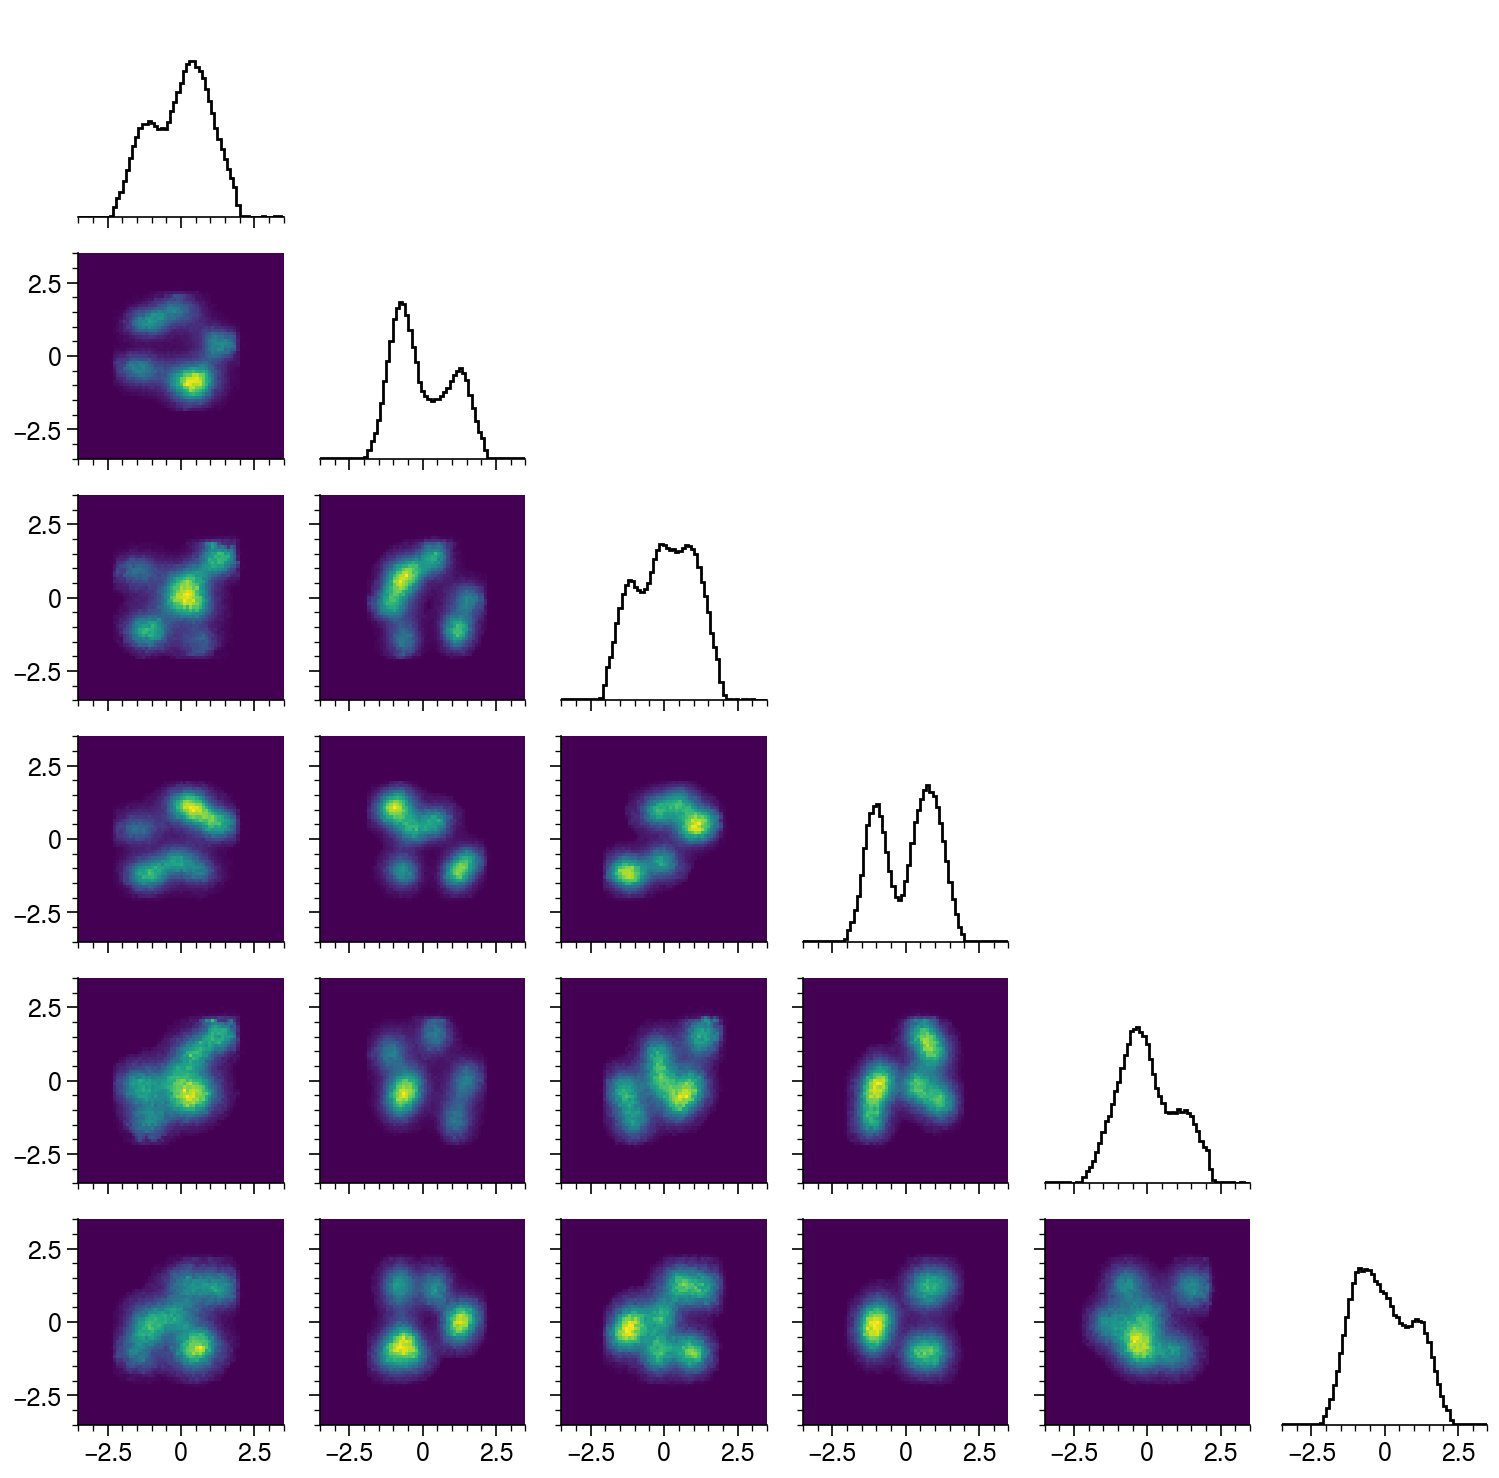

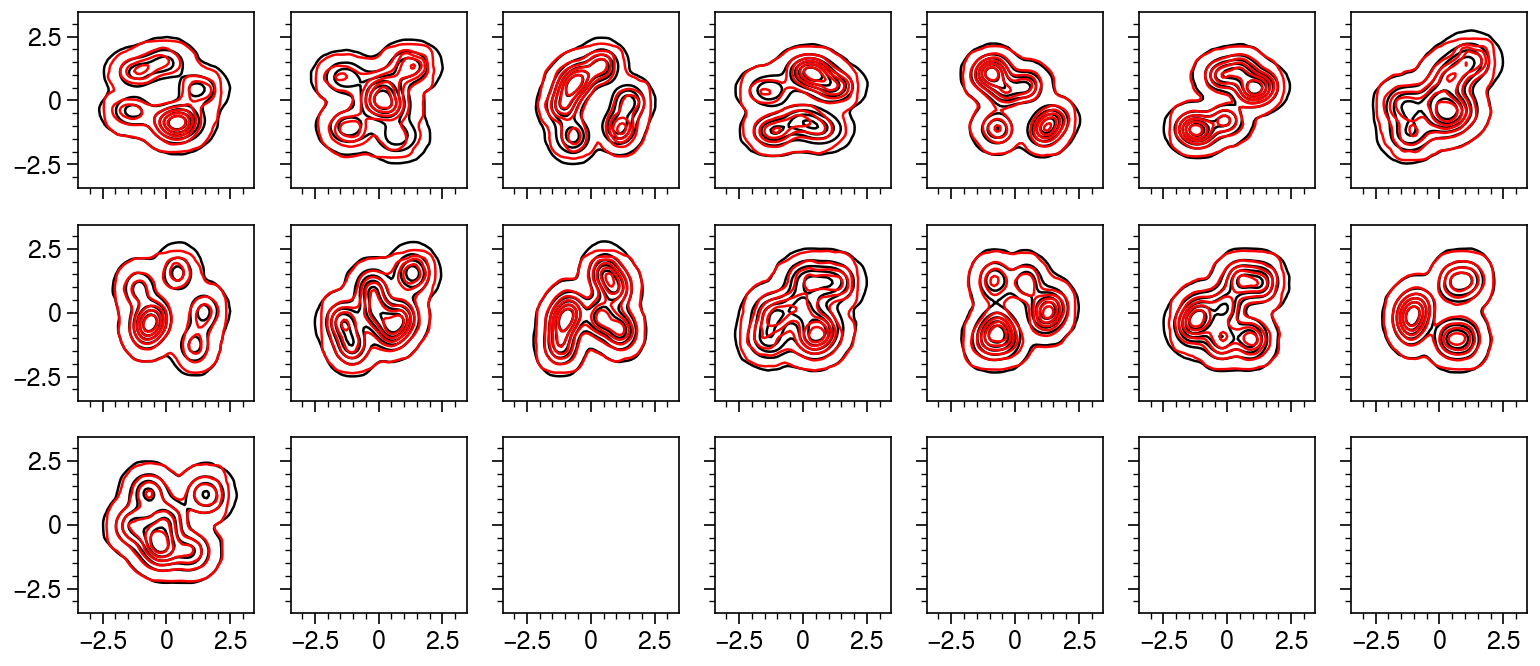

None
epoch = 2


  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▉                                                                                                                                                           | 64/1499 [00:00<00:02, 632.66it/s]

  9%|█████████████▊                                                                                                                                                   | 129/1499 [00:00<00:02, 640.17it/s]

 13%|████████████████████▊                                                                                                                                            | 194/1499 [00:00<00:02, 642.10it/s]

 17%|███████████████████████████▊                                                                                                                                     | 259/1499 [00:00<00:01, 642.31it/s]

 22%|██████████████████████████████████▊                                                                                                                              | 324/1499 [00:00<00:01, 644.79it/s]

 26%|█████████████████████████████████████████▉                                                                                                                       | 390/1499 [00:00<00:01, 648.45it/s]

 30%|████████████████████████████████████████████████▊                                                                                                                | 455/1499 [00:00<00:01, 640.57it/s]

 35%|███████████████████████████████████████████████████████▊                                                                                                         | 520/1499 [00:00<00:01, 637.14it/s]

 39%|██████████████████████████████████████████████████████████████▉                                                                                                  | 586/1499 [00:00<00:01, 643.41it/s]

 44%|██████████████████████████████████████████████████████████████████████▏                                                                                          | 653/1499 [00:01<00:01, 649.93it/s]

 48%|█████████████████████████████████████████████████████████████████████████████▎                                                                                   | 720/1499 [00:01<00:01, 653.21it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 787/1499 [00:01<00:01, 657.14it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 853/1499 [00:01<00:00, 656.44it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 920/1499 [00:01<00:00, 659.39it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 987/1499 [00:01<00:00, 662.14it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1054/1499 [00:01<00:00, 664.02it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1121/1499 [00:01<00:00, 663.56it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1188/1499 [00:01<00:00, 665.48it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1255/1499 [00:01<00:00, 664.60it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1322/1499 [00:02<00:00, 663.95it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1389/1499 [00:02<00:00, 663.90it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1456/1499 [00:02<00:00, 664.79it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 655.06it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|███████                                                                                                                                                           | 65/1499 [00:00<00:02, 646.02it/s]

  9%|█████████████▉                                                                                                                                                   | 130/1499 [00:00<00:02, 642.73it/s]

 13%|█████████████████████                                                                                                                                            | 196/1499 [00:00<00:02, 648.57it/s]

 17%|████████████████████████████▏                                                                                                                                    | 262/1499 [00:00<00:01, 652.31it/s]

 22%|███████████████████████████████████▏                                                                                                                             | 328/1499 [00:00<00:01, 653.78it/s]

 26%|██████████████████████████████████████████▎                                                                                                                      | 394/1499 [00:00<00:01, 655.15it/s]

 31%|█████████████████████████████████████████████████▍                                                                                                               | 460/1499 [00:00<00:01, 655.16it/s]

 35%|████████████████████████████████████████████████████████▍                                                                                                        | 526/1499 [00:00<00:01, 650.28it/s]

 40%|███████████████████████████████████████████████████████████████▋                                                                                                 | 593/1499 [00:00<00:01, 653.83it/s]

 44%|██████████████████████████████████████████████████████████████████████▊                                                                                          | 659/1499 [00:01<00:01, 655.44it/s]

 48%|█████████████████████████████████████████████████████████████████████████████▊                                                                                   | 725/1499 [00:01<00:01, 656.63it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████                                                                            | 792/1499 [00:01<00:01, 658.27it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 858/1499 [00:01<00:00, 646.38it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 923/1499 [00:01<00:00, 639.15it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 987/1499 [00:01<00:00, 633.31it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1051/1499 [00:01<00:00, 627.77it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1114/1499 [00:01<00:00, 625.64it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1177/1499 [00:01<00:00, 615.38it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1239/1499 [00:01<00:00, 611.83it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1301/1499 [00:02<00:00, 606.13it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1365/1499 [00:02<00:00, 614.34it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1431/1499 [00:02<00:00, 625.32it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1496/1499 [00:02<00:00, 631.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 637.35it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|███████                                                                                                                                                           | 65/1499 [00:00<00:02, 644.14it/s]

  9%|█████████████▉                                                                                                                                                   | 130/1499 [00:00<00:02, 642.52it/s]

 13%|████████████████████▉                                                                                                                                            | 195/1499 [00:00<00:02, 638.08it/s]

 17%|███████████████████████████▊                                                                                                                                     | 259/1499 [00:00<00:01, 637.41it/s]

 22%|██████████████████████████████████▉                                                                                                                              | 325/1499 [00:00<00:01, 642.22it/s]

 26%|█████████████████████████████████████████▉                                                                                                                       | 391/1499 [00:00<00:01, 644.98it/s]

 30%|████████████████████████████████████████████████▉                                                                                                                | 456/1499 [00:00<00:01, 623.97it/s]

 35%|███████████████████████████████████████████████████████▋                                                                                                         | 519/1499 [00:00<00:01, 619.29it/s]

 39%|██████████████████████████████████████████████████████████████▋                                                                                                  | 584/1499 [00:00<00:01, 626.52it/s]

 43%|█████████████████████████████████████████████████████████████████████▊                                                                                           | 650/1499 [00:01<00:01, 636.60it/s]

 48%|████████████████████████████████████████████████████████████████████████████▉                                                                                    | 716/1499 [00:01<00:01, 642.62it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████▉                                                                             | 781/1499 [00:01<00:01, 643.93it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 846/1499 [00:01<00:01, 636.85it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 910/1499 [00:01<00:00, 636.39it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 976/1499 [00:01<00:00, 641.10it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1041/1499 [00:01<00:00, 638.58it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1106/1499 [00:01<00:00, 641.23it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1172/1499 [00:01<00:00, 645.78it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1238/1499 [00:01<00:00, 649.57it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1305/1499 [00:02<00:00, 652.85it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1371/1499 [00:02<00:00, 654.22it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1437/1499 [00:02<00:00, 648.65it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 641.51it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▊                                                                                                                                                           | 63/1499 [00:00<00:02, 628.84it/s]

  9%|█████████████▋                                                                                                                                                   | 128/1499 [00:00<00:02, 635.98it/s]

 13%|████████████████████▋                                                                                                                                            | 193/1499 [00:00<00:02, 641.73it/s]

 17%|███████████████████████████▋                                                                                                                                     | 258/1499 [00:00<00:01, 643.57it/s]

 22%|██████████████████████████████████▋                                                                                                                              | 323/1499 [00:00<00:01, 640.60it/s]

 26%|█████████████████████████████████████████▋                                                                                                                       | 388/1499 [00:00<00:01, 642.60it/s]

 30%|████████████████████████████████████████████████▊                                                                                                                | 455/1499 [00:00<00:01, 648.86it/s]

 35%|███████████████████████████████████████████████████████▉                                                                                                         | 521/1499 [00:00<00:01, 651.79it/s]

 39%|███████████████████████████████████████████████████████████████                                                                                                  | 587/1499 [00:00<00:01, 649.20it/s]

 43%|██████████████████████████████████████████████████████████████████████                                                                                           | 652/1499 [00:01<00:01, 648.04it/s]

 48%|█████████████████████████████████████████████████████████████████████████████                                                                                    | 718/1499 [00:01<00:01, 650.35it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 784/1499 [00:01<00:01, 645.50it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 849/1499 [00:01<00:01, 645.78it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 915/1499 [00:01<00:00, 648.41it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 981/1499 [00:01<00:00, 651.48it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1047/1499 [00:01<00:00, 651.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 1113/1499 [00:01<00:00, 653.56it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1179/1499 [00:01<00:00, 653.55it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1245/1499 [00:01<00:00, 653.35it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1311/1499 [00:02<00:00, 647.88it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1377/1499 [00:02<00:00, 649.71it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1443/1499 [00:02<00:00, 652.25it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 648.84it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▋                                                                                                                                                           | 62/1499 [00:00<00:02, 612.98it/s]

  8%|█████████████▎                                                                                                                                                   | 124/1499 [00:00<00:02, 615.06it/s]

 12%|████████████████████                                                                                                                                             | 187/1499 [00:00<00:02, 617.52it/s]

 17%|██████████████████████████▋                                                                                                                                      | 249/1499 [00:00<00:02, 617.31it/s]

 21%|█████████████████████████████████▌                                                                                                                               | 312/1499 [00:00<00:01, 619.89it/s]

 25%|████████████████████████████████████████▏                                                                                                                        | 374/1499 [00:00<00:01, 619.44it/s]

 29%|██████████████████████████████████████████████▉                                                                                                                  | 437/1499 [00:00<00:01, 620.00it/s]

 33%|█████████████████████████████████████████████████████▊                                                                                                           | 501/1499 [00:00<00:01, 623.55it/s]

 38%|████████████████████████████████████████████████████████████▌                                                                                                    | 564/1499 [00:00<00:01, 621.51it/s]

 42%|███████████████████████████████████████████████████████████████████▎                                                                                             | 627/1499 [00:01<00:01, 620.94it/s]

 46%|██████████████████████████████████████████████████████████████████████████                                                                                       | 690/1499 [00:01<00:01, 617.34it/s]

 50%|████████████████████████████████████████████████████████████████████████████████▊                                                                                | 752/1499 [00:01<00:01, 613.68it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 815/1499 [00:01<00:01, 616.57it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 879/1499 [00:01<00:00, 623.18it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 945/1499 [00:01<00:00, 631.83it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1009/1499 [00:01<00:00, 630.32it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1073/1499 [00:01<00:00, 604.75it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1135/1499 [00:01<00:00, 608.59it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1198/1499 [00:01<00:00, 614.13it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1261/1499 [00:02<00:00, 618.30it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1324/1499 [00:02<00:00, 619.78it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1387/1499 [00:02<00:00, 622.29it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1450/1499 [00:02<00:00, 623.28it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 619.65it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▌                                                                                                                                                           | 61/1499 [00:00<00:02, 608.63it/s]

  8%|█████████████▎                                                                                                                                                   | 124/1499 [00:00<00:02, 617.50it/s]

 12%|████████████████████                                                                                                                                             | 187/1499 [00:00<00:02, 620.30it/s]

 17%|██████████████████████████▊                                                                                                                                      | 250/1499 [00:00<00:02, 616.45it/s]

 21%|█████████████████████████████████▌                                                                                                                               | 312/1499 [00:00<00:01, 614.27it/s]

 25%|████████████████████████████████████████▏                                                                                                                        | 374/1499 [00:00<00:01, 609.36it/s]

 29%|██████████████████████████████████████████████▋                                                                                                                  | 435/1499 [00:00<00:01, 608.41it/s]

 33%|█████████████████████████████████████████████████████▍                                                                                                           | 497/1499 [00:00<00:01, 611.49it/s]

 37%|████████████████████████████████████████████████████████████▎                                                                                                    | 562/1499 [00:00<00:01, 622.94it/s]

 42%|███████████████████████████████████████████████████████████████████▎                                                                                             | 627/1499 [00:01<00:01, 630.02it/s]

 46%|██████████████████████████████████████████████████████████████████████████▎                                                                                      | 692/1499 [00:01<00:01, 633.57it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████▎                                                                               | 757/1499 [00:01<00:01, 636.45it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 823/1499 [00:01<00:01, 640.98it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 889/1499 [00:01<00:00, 644.83it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 955/1499 [00:01<00:00, 646.07it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1021/1499 [00:01<00:00, 647.55it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1086/1499 [00:01<00:00, 647.00it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1153/1499 [00:01<00:00, 651.89it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1219/1499 [00:01<00:00, 651.45it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1285/1499 [00:02<00:00, 652.60it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1351/1499 [00:02<00:00, 654.49it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1417/1499 [00:02<00:00, 653.77it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1484/1499 [00:02<00:00, 657.03it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 638.07it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▉                                                                                                                                                           | 64/1499 [00:00<00:02, 633.79it/s]

  9%|█████████████▊                                                                                                                                                   | 129/1499 [00:00<00:02, 640.23it/s]

 13%|█████████████████████                                                                                                                                            | 196/1499 [00:00<00:02, 649.48it/s]

 18%|████████████████████████████▏                                                                                                                                    | 263/1499 [00:00<00:01, 654.10it/s]

 22%|███████████████████████████████████▎                                                                                                                             | 329/1499 [00:00<00:01, 651.53it/s]

 26%|██████████████████████████████████████████▌                                                                                                                      | 396/1499 [00:00<00:01, 654.72it/s]

 31%|█████████████████████████████████████████████████▌                                                                                                               | 462/1499 [00:00<00:01, 655.67it/s]

 35%|████████████████████████████████████████████████████████▋                                                                                                        | 528/1499 [00:00<00:01, 656.76it/s]

 40%|███████████████████████████████████████████████████████████████▉                                                                                                 | 595/1499 [00:00<00:01, 657.90it/s]

 44%|███████████████████████████████████████████████████████████████████████                                                                                          | 662/1499 [00:01<00:01, 660.11it/s]

 49%|██████████████████████████████████████████████████████████████████████████████▎                                                                                  | 729/1499 [00:01<00:01, 656.79it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 795/1499 [00:01<00:01, 655.40it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 861/1499 [00:01<00:00, 655.05it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 928/1499 [00:01<00:00, 656.64it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 994/1499 [00:01<00:00, 654.06it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1060/1499 [00:01<00:00, 653.09it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1126/1499 [00:01<00:00, 652.12it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1193/1499 [00:01<00:00, 655.97it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1260/1499 [00:01<00:00, 657.97it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1326/1499 [00:02<00:00, 658.51it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1393/1499 [00:02<00:00, 661.00it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1460/1499 [00:02<00:00, 662.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 655.92it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▉                                                                                                                                                           | 64/1499 [00:00<00:02, 639.64it/s]

  9%|█████████████▊                                                                                                                                                   | 129/1499 [00:00<00:02, 644.45it/s]

 13%|████████████████████▉                                                                                                                                            | 195/1499 [00:00<00:02, 651.04it/s]

 17%|████████████████████████████                                                                                                                                     | 261/1499 [00:00<00:01, 651.02it/s]

 22%|███████████████████████████████████                                                                                                                              | 327/1499 [00:00<00:01, 653.11it/s]

 26%|██████████████████████████████████████████▏                                                                                                                      | 393/1499 [00:00<00:01, 655.21it/s]

 31%|█████████████████████████████████████████████████▍                                                                                                               | 460/1499 [00:00<00:01, 657.71it/s]

 35%|████████████████████████████████████████████████████████▍                                                                                                        | 526/1499 [00:00<00:01, 656.85it/s]

 40%|███████████████████████████████████████████████████████████████▋                                                                                                 | 593/1499 [00:00<00:01, 659.04it/s]

 44%|██████████████████████████████████████████████████████████████████████▉                                                                                          | 660/1499 [00:01<00:01, 661.04it/s]

 48%|██████████████████████████████████████████████████████████████████████████████                                                                                   | 727/1499 [00:01<00:01, 662.54it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 794/1499 [00:01<00:01, 660.72it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 861/1499 [00:01<00:00, 662.30it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 928/1499 [00:01<00:00, 663.65it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 995/1499 [00:01<00:00, 661.76it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1062/1499 [00:01<00:00, 660.44it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1129/1499 [00:01<00:00, 662.32it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 1196/1499 [00:01<00:00, 664.16it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1263/1499 [00:01<00:00, 665.57it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1330/1499 [00:02<00:00, 666.67it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1397/1499 [00:02<00:00, 664.40it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1464/1499 [00:02<00:00, 665.51it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 660.62it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|███████▏                                                                                                                                                          | 66/1499 [00:00<00:02, 652.26it/s]

  9%|██████████████▏                                                                                                                                                  | 132/1499 [00:00<00:02, 656.53it/s]

 13%|█████████████████████▎                                                                                                                                           | 199/1499 [00:00<00:01, 659.14it/s]

 18%|████████████████████████████▍                                                                                                                                    | 265/1499 [00:00<00:01, 656.05it/s]

 22%|███████████████████████████████████▋                                                                                                                             | 332/1499 [00:00<00:01, 658.73it/s]

 27%|██████████████████████████████████████████▊                                                                                                                      | 399/1499 [00:00<00:01, 660.49it/s]

 31%|██████████████████████████████████████████████████                                                                                                               | 466/1499 [00:00<00:01, 662.34it/s]

 36%|█████████████████████████████████████████████████████████▏                                                                                                       | 533/1499 [00:00<00:01, 663.37it/s]

 40%|████████████████████████████████████████████████████████████████▍                                                                                                | 600/1499 [00:00<00:01, 661.35it/s]

 44%|███████████████████████████████████████████████████████████████████████▋                                                                                         | 667/1499 [00:01<00:01, 659.96it/s]

 49%|██████████████████████████████████████████████████████████████████████████████▋                                                                                  | 733/1499 [00:01<00:01, 659.28it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 800/1499 [00:01<00:01, 661.72it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 867/1499 [00:01<00:00, 659.69it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 933/1499 [00:01<00:00, 659.11it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1000/1499 [00:01<00:00, 661.46it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1067/1499 [00:01<00:00, 662.67it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1134/1499 [00:01<00:00, 661.33it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 1201/1499 [00:01<00:00, 662.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1268/1499 [00:01<00:00, 663.70it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1335/1499 [00:02<00:00, 662.13it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1402/1499 [00:02<00:00, 660.90it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1469/1499 [00:02<00:00, 660.27it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 660.68it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|███████▏                                                                                                                                                          | 66/1499 [00:00<00:02, 652.91it/s]

  9%|██████████████▎                                                                                                                                                  | 133/1499 [00:00<00:02, 657.21it/s]

 13%|█████████████████████▍                                                                                                                                           | 200/1499 [00:00<00:01, 659.65it/s]

 18%|████████████████████████████▌                                                                                                                                    | 266/1499 [00:00<00:01, 657.79it/s]

 22%|███████████████████████████████████▊                                                                                                                             | 333/1499 [00:00<00:01, 660.28it/s]

 27%|██████████████████████████████████████████▉                                                                                                                      | 400/1499 [00:00<00:01, 659.51it/s]

 31%|██████████████████████████████████████████████████                                                                                                               | 466/1499 [00:00<00:01, 659.39it/s]

 36%|█████████████████████████████████████████████████████████▏                                                                                                       | 533/1499 [00:00<00:01, 659.67it/s]

 40%|████████████████████████████████████████████████████████████████▍                                                                                                | 600/1499 [00:00<00:01, 662.06it/s]

 44%|███████████████████████████████████████████████████████████████████████▋                                                                                         | 667/1499 [00:01<00:01, 661.71it/s]

 49%|██████████████████████████████████████████████████████████████████████████████▊                                                                                  | 734/1499 [00:01<00:01, 661.29it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████                                                                           | 801/1499 [00:01<00:01, 660.73it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 868/1499 [00:01<00:00, 663.02it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 935/1499 [00:01<00:00, 663.66it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1002/1499 [00:01<00:00, 659.14it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1068/1499 [00:01<00:00, 654.65it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1134/1499 [00:01<00:00, 650.40it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1200/1499 [00:01<00:00, 652.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1266/1499 [00:01<00:00, 650.16it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1333/1499 [00:02<00:00, 654.68it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1399/1499 [00:02<00:00, 653.77it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1465/1499 [00:02<00:00, 653.32it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 656.68it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▉                                                                                                                                                           | 64/1499 [00:00<00:02, 630.71it/s]

  9%|█████████████▊                                                                                                                                                   | 129/1499 [00:00<00:02, 637.77it/s]

 13%|████████████████████▋                                                                                                                                            | 193/1499 [00:00<00:02, 628.23it/s]

 17%|███████████████████████████▍                                                                                                                                     | 256/1499 [00:00<00:01, 625.66it/s]

 21%|██████████████████████████████████▎                                                                                                                              | 319/1499 [00:00<00:01, 623.18it/s]

 25%|█████████████████████████████████████████                                                                                                                        | 382/1499 [00:00<00:01, 619.98it/s]

 30%|███████████████████████████████████████████████▊                                                                                                                 | 445/1499 [00:00<00:01, 620.89it/s]

 34%|██████████████████████████████████████████████████████▌                                                                                                          | 508/1499 [00:00<00:01, 621.67it/s]

 38%|█████████████████████████████████████████████████████████████▎                                                                                                   | 571/1499 [00:00<00:01, 616.63it/s]

 42%|████████████████████████████████████████████████████████████████████▎                                                                                            | 636/1499 [00:01<00:01, 624.63it/s]

 47%|███████████████████████████████████████████████████████████████████████████▎                                                                                     | 701/1499 [00:01<00:01, 629.76it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████                                                                               | 764/1499 [00:01<00:01, 625.98it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 828/1499 [00:01<00:01, 629.11it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 894/1499 [00:01<00:00, 637.83it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 958/1499 [00:01<00:00, 633.31it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1022/1499 [00:01<00:00, 629.35it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1086/1499 [00:01<00:00, 631.36it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1150/1499 [00:01<00:00, 616.00it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1215/1499 [00:01<00:00, 625.72it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1278/1499 [00:02<00:00, 625.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1342/1499 [00:02<00:00, 629.08it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1406/1499 [00:02<00:00, 631.18it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1471/1499 [00:02<00:00, 634.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 628.31it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▉                                                                                                                                                           | 64/1499 [00:00<00:02, 633.04it/s]

  9%|█████████████▊                                                                                                                                                   | 129/1499 [00:00<00:02, 640.12it/s]

 13%|████████████████████▊                                                                                                                                            | 194/1499 [00:00<00:02, 638.71it/s]

 17%|███████████████████████████▋                                                                                                                                     | 258/1499 [00:00<00:01, 635.97it/s]

 21%|██████████████████████████████████▌                                                                                                                              | 322/1499 [00:00<00:01, 636.17it/s]

 26%|█████████████████████████████████████████▋                                                                                                                       | 388/1499 [00:00<00:01, 642.55it/s]

 30%|████████████████████████████████████████████████▊                                                                                                                | 454/1499 [00:00<00:01, 646.12it/s]

 35%|███████████████████████████████████████████████████████▋                                                                                                         | 519/1499 [00:00<00:01, 644.55it/s]

 39%|██████████████████████████████████████████████████████████████▊                                                                                                  | 585/1499 [00:00<00:01, 647.47it/s]

 43%|█████████████████████████████████████████████████████████████████████▉                                                                                           | 651/1499 [00:01<00:01, 650.94it/s]

 48%|█████████████████████████████████████████████████████████████████████████████                                                                                    | 717/1499 [00:01<00:01, 648.37it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████▉                                                                             | 782/1499 [00:01<00:01, 647.20it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 847/1499 [00:01<00:01, 645.37it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 912/1499 [00:01<00:00, 637.54it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 977/1499 [00:01<00:00, 639.74it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1042/1499 [00:01<00:00, 640.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1107/1499 [00:01<00:00, 641.09it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1172/1499 [00:01<00:00, 643.15it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1238/1499 [00:01<00:00, 646.15it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1304/1499 [00:02<00:00, 649.80it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1370/1499 [00:02<00:00, 650.47it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1436/1499 [00:02<00:00, 652.82it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 645.63it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|███████                                                                                                                                                           | 65/1499 [00:00<00:02, 644.62it/s]

  9%|██████████████                                                                                                                                                   | 131/1499 [00:00<00:02, 649.54it/s]

 13%|█████████████████████▏                                                                                                                                           | 197/1499 [00:00<00:01, 652.19it/s]

 18%|████████████████████████████▏                                                                                                                                    | 263/1499 [00:00<00:01, 646.81it/s]

 22%|███████████████████████████████████▏                                                                                                                             | 328/1499 [00:00<00:01, 646.90it/s]

 26%|██████████████████████████████████████████▏                                                                                                                      | 393/1499 [00:00<00:01, 644.79it/s]

 31%|█████████████████████████████████████████████████▎                                                                                                               | 459/1499 [00:00<00:01, 649.10it/s]

 35%|████████████████████████████████████████████████████████▍                                                                                                        | 525/1499 [00:00<00:01, 652.35it/s]

 39%|███████████████████████████████████████████████████████████████▍                                                                                                 | 591/1499 [00:00<00:01, 646.14it/s]

 44%|██████████████████████████████████████████████████████████████████████▌                                                                                          | 657/1499 [00:01<00:01, 649.44it/s]

 48%|█████████████████████████████████████████████████████████████████████████████▋                                                                                   | 723/1499 [00:01<00:01, 650.82it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 789/1499 [00:01<00:01, 648.61it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 854/1499 [00:01<00:00, 646.24it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 920/1499 [00:01<00:00, 649.77it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 987/1499 [00:01<00:00, 653.45it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1053/1499 [00:01<00:00, 652.78it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1120/1499 [00:01<00:00, 655.79it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1186/1499 [00:01<00:00, 656.72it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1252/1499 [00:01<00:00, 654.71it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1318/1499 [00:02<00:00, 652.79it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1384/1499 [00:02<00:00, 651.57it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1450/1499 [00:02<00:00, 649.73it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 650.33it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|███████▏                                                                                                                                                          | 66/1499 [00:00<00:02, 652.16it/s]

  9%|██████████████▏                                                                                                                                                  | 132/1499 [00:00<00:02, 645.20it/s]

 13%|█████████████████████▎                                                                                                                                           | 198/1499 [00:00<00:01, 651.31it/s]

 18%|████████████████████████████▎                                                                                                                                    | 264/1499 [00:00<00:01, 651.36it/s]

 22%|███████████████████████████████████▍                                                                                                                             | 330/1499 [00:00<00:01, 648.33it/s]

 26%|██████████████████████████████████████████▌                                                                                                                      | 396/1499 [00:00<00:01, 649.81it/s]

 31%|█████████████████████████████████████████████████▌                                                                                                               | 461/1499 [00:00<00:01, 638.17it/s]

 35%|████████████████████████████████████████████████████████▍                                                                                                        | 525/1499 [00:00<00:01, 630.00it/s]

 39%|███████████████████████████████████████████████████████████████▎                                                                                                 | 589/1499 [00:00<00:01, 632.50it/s]

 44%|██████████████████████████████████████████████████████████████████████▏                                                                                          | 654/1499 [00:01<00:01, 635.04it/s]

 48%|█████████████████████████████████████████████████████████████████████████████▎                                                                                   | 720/1499 [00:01<00:01, 639.84it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 786/1499 [00:01<00:01, 645.11it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 852/1499 [00:01<00:00, 649.56it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 918/1499 [00:01<00:00, 651.73it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 984/1499 [00:01<00:00, 653.96it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1050/1499 [00:01<00:00, 654.41it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1116/1499 [00:01<00:00, 655.49it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1182/1499 [00:01<00:00, 654.72it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1249/1499 [00:01<00:00, 656.33it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1315/1499 [00:02<00:00, 654.85it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1381/1499 [00:02<00:00, 653.86it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1448/1499 [00:02<00:00, 657.19it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 649.46it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|███████                                                                                                                                                           | 65/1499 [00:00<00:02, 641.67it/s]

  9%|█████████████▉                                                                                                                                                   | 130/1499 [00:00<00:02, 638.54it/s]

 13%|████████████████████▊                                                                                                                                            | 194/1499 [00:00<00:02, 638.82it/s]

 17%|███████████████████████████▋                                                                                                                                     | 258/1499 [00:00<00:01, 638.49it/s]

 22%|██████████████████████████████████▋                                                                                                                              | 323/1499 [00:00<00:01, 642.07it/s]

 26%|█████████████████████████████████████████▋                                                                                                                       | 388/1499 [00:00<00:01, 644.39it/s]

 30%|████████████████████████████████████████████████▋                                                                                                                | 453/1499 [00:00<00:01, 641.23it/s]

 35%|███████████████████████████████████████████████████████▋                                                                                                         | 518/1499 [00:00<00:01, 640.25it/s]

 39%|██████████████████████████████████████████████████████████████▌                                                                                                  | 583/1499 [00:00<00:01, 642.23it/s]

 43%|█████████████████████████████████████████████████████████████████████▌                                                                                           | 648/1499 [00:01<00:01, 641.38it/s]

 48%|████████████████████████████████████████████████████████████████████████████▌                                                                                    | 713/1499 [00:01<00:01, 640.43it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████▌                                                                             | 778/1499 [00:01<00:01, 642.54it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 845/1499 [00:01<00:01, 648.39it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 910/1499 [00:01<00:00, 647.74it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 975/1499 [00:01<00:00, 647.47it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1040/1499 [00:01<00:00, 637.19it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1104/1499 [00:01<00:00, 629.24it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1167/1499 [00:01<00:00, 626.02it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 1230/1499 [00:01<00:00, 619.43it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1294/1499 [00:02<00:00, 624.75it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1357/1499 [00:02<00:00, 625.46it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1420/1499 [00:02<00:00, 622.20it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1483/1499 [00:02<00:00, 621.12it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 634.25it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▋                                                                                                                                                           | 62/1499 [00:00<00:02, 611.83it/s]

  8%|█████████████▎                                                                                                                                                   | 124/1499 [00:00<00:02, 611.52it/s]

 12%|███████████████████▉                                                                                                                                             | 186/1499 [00:00<00:02, 613.88it/s]

 17%|██████████████████████████▋                                                                                                                                      | 249/1499 [00:00<00:02, 617.12it/s]

 21%|█████████████████████████████████▍                                                                                                                               | 311/1499 [00:00<00:01, 617.83it/s]

 25%|████████████████████████████████████████▍                                                                                                                        | 376/1499 [00:00<00:01, 628.20it/s]

 29%|███████████████████████████████████████████████▏                                                                                                                 | 439/1499 [00:00<00:01, 624.26it/s]

 33%|█████████████████████████████████████████████████████▉                                                                                                           | 502/1499 [00:00<00:01, 622.65it/s]

 38%|████████████████████████████████████████████████████████████▋                                                                                                    | 565/1499 [00:00<00:01, 624.55it/s]

 42%|███████████████████████████████████████████████████████████████████▍                                                                                             | 628/1499 [00:01<00:01, 622.93it/s]

 46%|██████████████████████████████████████████████████████████████████████████▎                                                                                      | 692/1499 [00:01<00:01, 625.94it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████▏                                                                               | 756/1499 [00:01<00:01, 628.55it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 819/1499 [00:01<00:01, 625.97it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 882/1499 [00:01<00:00, 624.10it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 946/1499 [00:01<00:00, 626.90it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1010/1499 [00:01<00:00, 628.15it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1074/1499 [00:01<00:00, 629.31it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1137/1499 [00:01<00:00, 625.85it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1200/1499 [00:01<00:00, 625.01it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1263/1499 [00:02<00:00, 620.92it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1326/1499 [00:02<00:00, 622.08it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1392/1499 [00:02<00:00, 630.40it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1458/1499 [00:02<00:00, 637.18it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 626.48it/s]

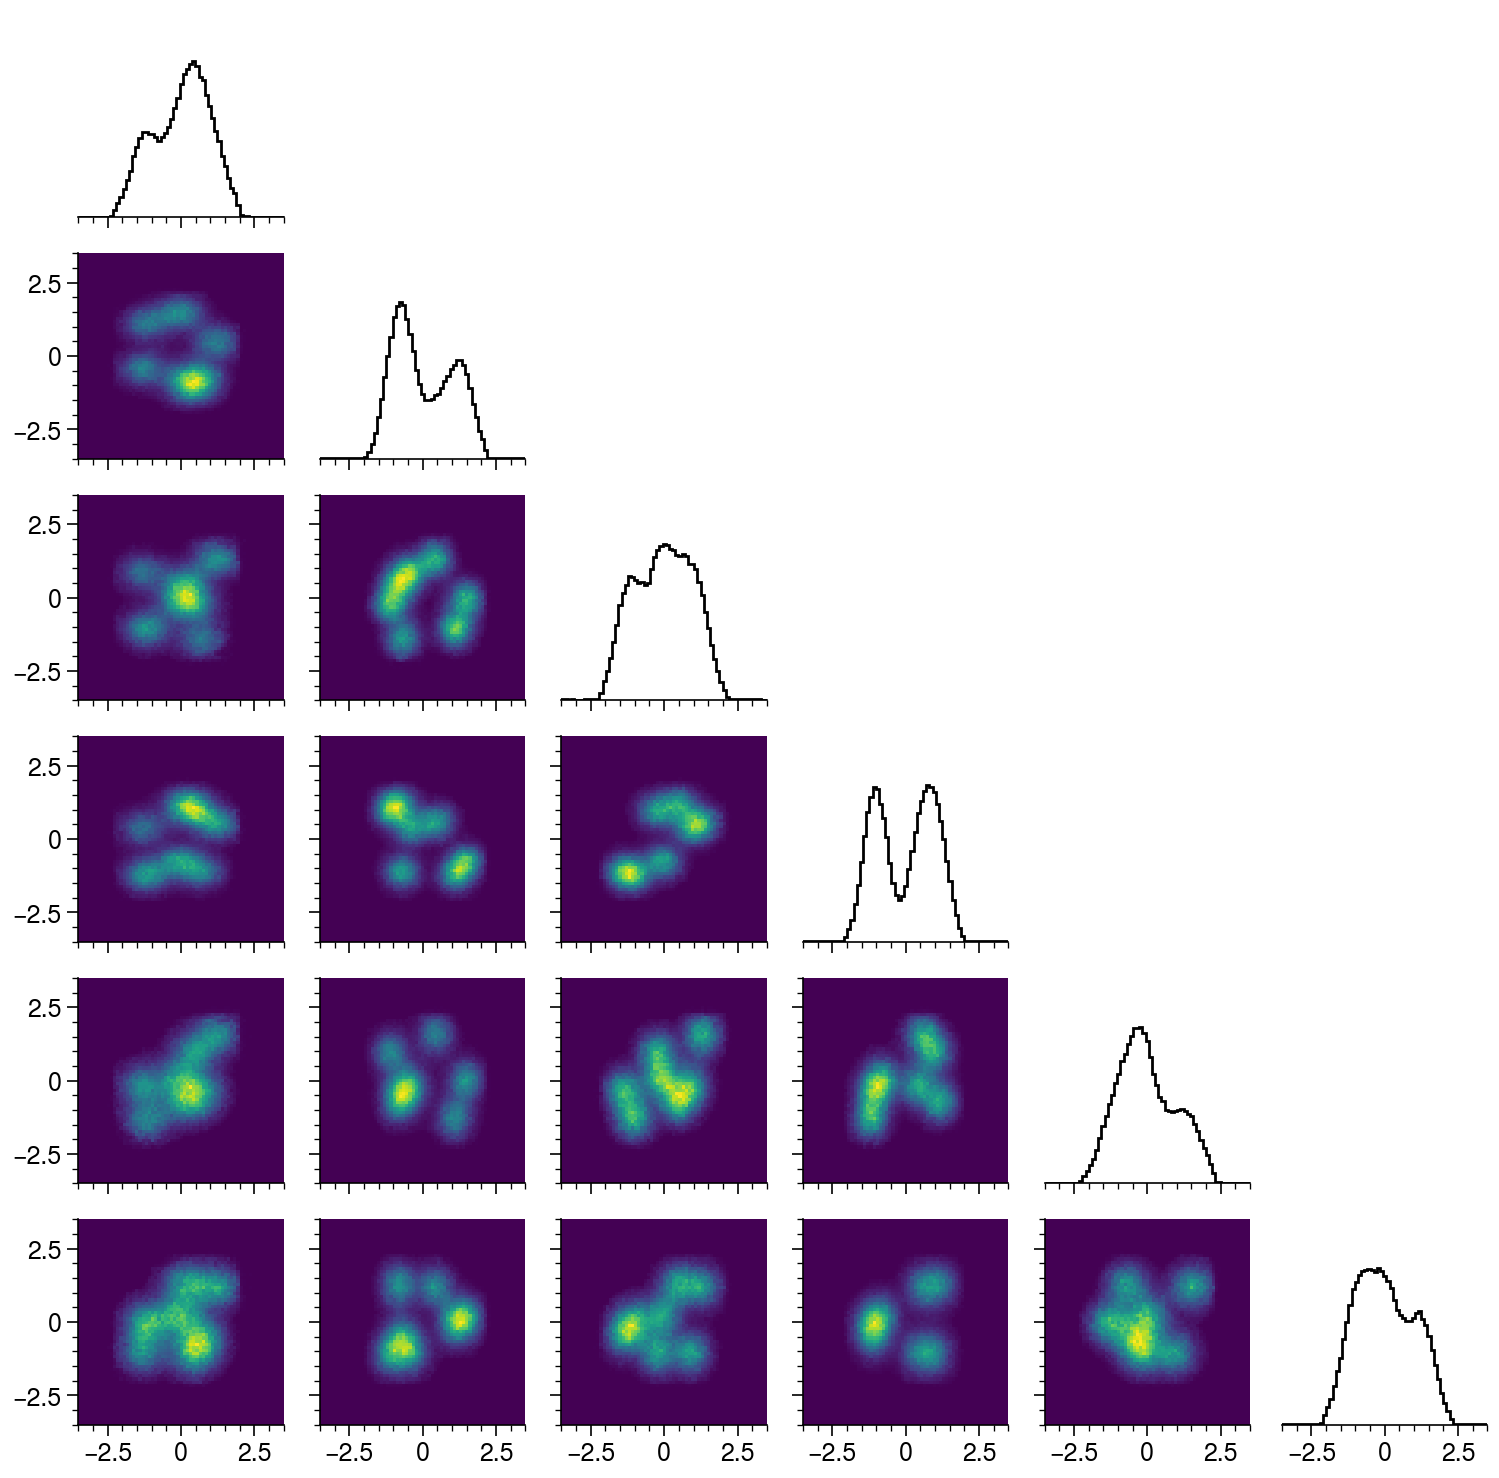

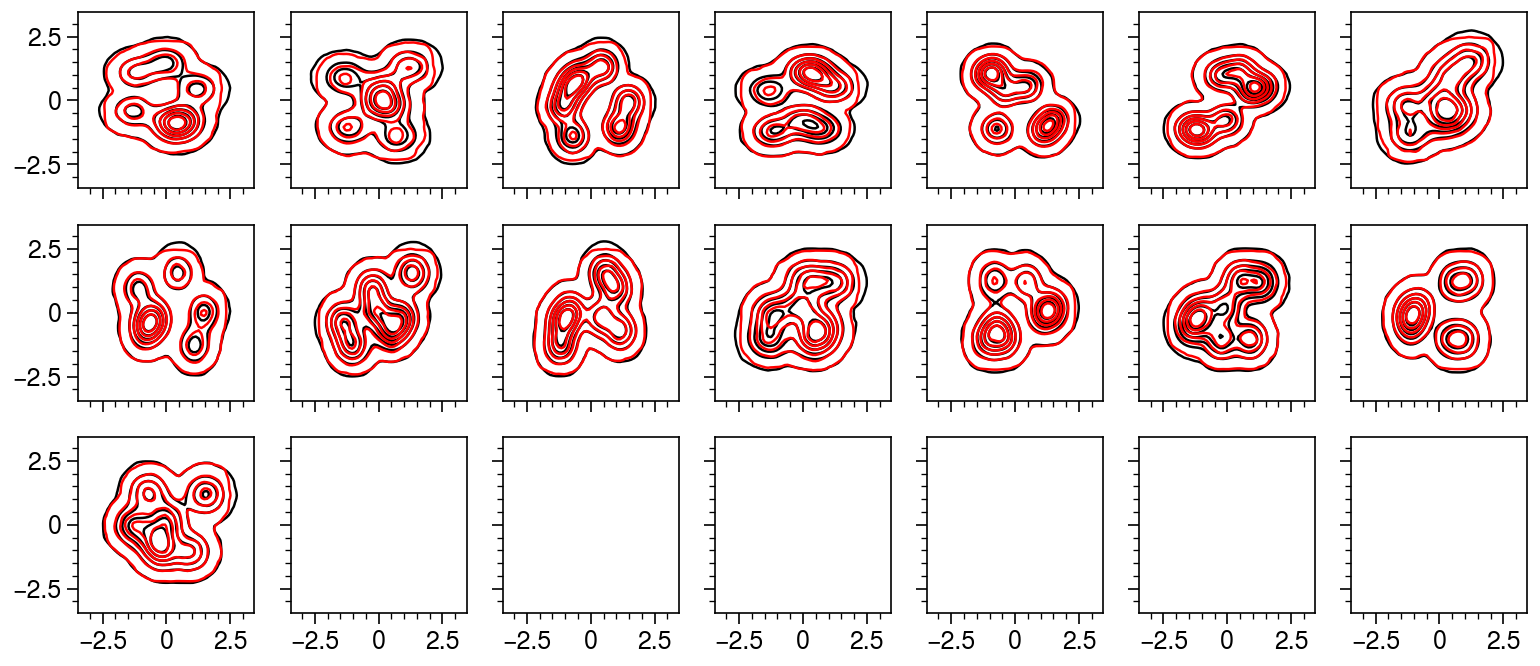

None
epoch = 3


  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▌                                                                                                                                                           | 61/1499 [00:00<00:02, 606.26it/s]

  8%|█████████████                                                                                                                                                    | 122/1499 [00:00<00:02, 606.88it/s]

 12%|███████████████████▋                                                                                                                                             | 183/1499 [00:00<00:02, 608.09it/s]

 16%|██████████████████████████▎                                                                                                                                      | 245/1499 [00:00<00:02, 612.18it/s]

 20%|████████████████████████████████▉                                                                                                                                | 307/1499 [00:00<00:01, 613.17it/s]

 25%|███████████████████████████████████████▊                                                                                                                         | 371/1499 [00:00<00:01, 622.16it/s]

 29%|██████████████████████████████████████████████▌                                                                                                                  | 434/1499 [00:00<00:01, 624.36it/s]

 33%|█████████████████████████████████████████████████████▍                                                                                                           | 497/1499 [00:00<00:01, 623.30it/s]

 37%|████████████████████████████████████████████████████████████▏                                                                                                    | 560/1499 [00:00<00:01, 621.82it/s]

 42%|███████████████████████████████████████████████████████████████████                                                                                              | 624/1499 [00:01<00:01, 625.68it/s]

 46%|█████████████████████████████████████████████████████████████████████████▊                                                                                       | 687/1499 [00:01<00:01, 625.11it/s]

 50%|████████████████████████████████████████████████████████████████████████████████▋                                                                                | 751/1499 [00:01<00:01, 627.33it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 814/1499 [00:01<00:01, 626.44it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 877/1499 [00:01<00:00, 623.83it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 940/1499 [00:01<00:00, 624.38it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 1003/1499 [00:01<00:00, 624.92it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1068/1499 [00:01<00:00, 629.57it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1131/1499 [00:01<00:00, 629.24it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1194/1499 [00:01<00:00, 628.89it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1257/1499 [00:02<00:00, 628.32it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1320/1499 [00:02<00:00, 625.58it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1383/1499 [00:02<00:00, 625.05it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1449/1499 [00:02<00:00, 633.81it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 625.31it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▋                                                                                                                                                           | 62/1499 [00:00<00:02, 616.09it/s]

  8%|█████████████▎                                                                                                                                                   | 124/1499 [00:00<00:02, 616.25it/s]

 13%|████████████████████▏                                                                                                                                            | 188/1499 [00:00<00:02, 623.33it/s]

 17%|██████████████████████████▉                                                                                                                                      | 251/1499 [00:00<00:02, 620.65it/s]

 21%|█████████████████████████████████▋                                                                                                                               | 314/1499 [00:00<00:01, 616.62it/s]

 25%|████████████████████████████████████████▍                                                                                                                        | 376/1499 [00:00<00:01, 615.94it/s]

 29%|███████████████████████████████████████████████▏                                                                                                                 | 439/1499 [00:00<00:01, 618.09it/s]

 34%|██████████████████████████████████████████████████████▏                                                                                                          | 505/1499 [00:00<00:01, 628.28it/s]

 38%|█████████████████████████████████████████████████████████████                                                                                                    | 568/1499 [00:00<00:01, 627.05it/s]

 42%|███████████████████████████████████████████████████████████████████▉                                                                                             | 633/1499 [00:01<00:01, 632.45it/s]

 47%|██████████████████████████████████████████████████████████████████████████▉                                                                                      | 698/1499 [00:01<00:01, 637.50it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████▊                                                                               | 762/1499 [00:01<00:01, 636.09it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 826/1499 [00:01<00:01, 633.13it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 890/1499 [00:01<00:00, 632.81it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 954/1499 [00:01<00:00, 628.34it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1018/1499 [00:01<00:00, 630.06it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 1082/1499 [00:01<00:00, 628.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1146/1499 [00:01<00:00, 630.36it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1210/1499 [00:01<00:00, 628.87it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1273/1499 [00:02<00:00, 624.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1337/1499 [00:02<00:00, 626.37it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1402/1499 [00:02<00:00, 631.58it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1466/1499 [00:02<00:00, 632.70it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 628.05it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▉                                                                                                                                                           | 64/1499 [00:00<00:02, 632.98it/s]

  9%|█████████████▋                                                                                                                                                   | 128/1499 [00:00<00:02, 625.02it/s]

 13%|████████████████████▌                                                                                                                                            | 191/1499 [00:00<00:02, 622.77it/s]

 17%|███████████████████████████▎                                                                                                                                     | 254/1499 [00:00<00:02, 621.91it/s]

 21%|██████████████████████████████████                                                                                                                               | 317/1499 [00:00<00:01, 622.70it/s]

 25%|████████████████████████████████████████▉                                                                                                                        | 381/1499 [00:00<00:01, 625.78it/s]

 30%|███████████████████████████████████████████████▉                                                                                                                 | 446/1499 [00:00<00:01, 631.50it/s]

 34%|██████████████████████████████████████████████████████▊                                                                                                          | 510/1499 [00:00<00:01, 631.71it/s]

 38%|█████████████████████████████████████████████████████████████▋                                                                                                   | 574/1499 [00:00<00:01, 630.33it/s]

 43%|████████████████████████████████████████████████████████████████████▌                                                                                            | 638/1499 [00:01<00:01, 628.78it/s]

 47%|███████████████████████████████████████████████████████████████████████████▎                                                                                     | 701/1499 [00:01<00:01, 627.64it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████▏                                                                              | 765/1499 [00:01<00:01, 630.58it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████                                                                        | 829/1499 [00:01<00:01, 631.81it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 893/1499 [00:01<00:00, 630.20it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 957/1499 [00:01<00:00, 628.69it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1020/1499 [00:01<00:00, 625.42it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1083/1499 [00:01<00:00, 625.16it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1148/1499 [00:01<00:00, 630.82it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1212/1499 [00:01<00:00, 630.25it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1276/1499 [00:02<00:00, 627.58it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1339/1499 [00:02<00:00, 625.58it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1402/1499 [00:02<00:00, 625.69it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1468/1499 [00:02<00:00, 634.67it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 629.06it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▌                                                                                                                                                           | 61/1499 [00:00<00:02, 603.35it/s]

  8%|█████████████▎                                                                                                                                                   | 124/1499 [00:00<00:02, 617.88it/s]

 12%|████████████████████                                                                                                                                             | 187/1499 [00:00<00:02, 618.91it/s]

 17%|██████████████████████████▊                                                                                                                                      | 250/1499 [00:00<00:02, 623.11it/s]

 21%|█████████████████████████████████▌                                                                                                                               | 313/1499 [00:00<00:01, 617.48it/s]

 25%|████████████████████████████████████████▎                                                                                                                        | 375/1499 [00:00<00:01, 616.06it/s]

 29%|███████████████████████████████████████████████                                                                                                                  | 438/1499 [00:00<00:01, 619.94it/s]

 33%|█████████████████████████████████████████████████████▉                                                                                                           | 502/1499 [00:00<00:01, 624.41it/s]

 38%|████████████████████████████████████████████████████████████▋                                                                                                    | 565/1499 [00:00<00:01, 624.40it/s]

 42%|███████████████████████████████████████████████████████████████████▍                                                                                             | 628/1499 [00:01<00:01, 623.16it/s]

 46%|██████████████████████████████████████████████████████████████████████████▏                                                                                      | 691/1499 [00:01<00:01, 625.09it/s]

 50%|████████████████████████████████████████████████████████████████████████████████▉                                                                                | 754/1499 [00:01<00:01, 626.40it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 817/1499 [00:01<00:01, 626.60it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 880/1499 [00:01<00:00, 625.00it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 943/1499 [00:01<00:00, 625.45it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1006/1499 [00:01<00:00, 623.23it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1070/1499 [00:01<00:00, 626.11it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1133/1499 [00:01<00:00, 625.15it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1198/1499 [00:01<00:00, 632.28it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1262/1499 [00:02<00:00, 632.34it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1326/1499 [00:02<00:00, 625.85it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1389/1499 [00:02<00:00, 621.75it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1452/1499 [00:02<00:00, 623.73it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 623.95it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▋                                                                                                                                                           | 62/1499 [00:00<00:02, 618.52it/s]

  8%|█████████████▍                                                                                                                                                   | 125/1499 [00:00<00:02, 622.40it/s]

 13%|████████████████████▏                                                                                                                                            | 188/1499 [00:00<00:02, 625.34it/s]

 17%|███████████████████████████                                                                                                                                      | 252/1499 [00:00<00:01, 628.80it/s]

 21%|█████████████████████████████████▉                                                                                                                               | 316/1499 [00:00<00:01, 629.37it/s]

 25%|████████████████████████████████████████▋                                                                                                                        | 379/1499 [00:00<00:01, 627.54it/s]

 29%|███████████████████████████████████████████████▍                                                                                                                 | 442/1499 [00:00<00:01, 626.37it/s]

 34%|██████████████████████████████████████████████████████▏                                                                                                          | 505/1499 [00:00<00:01, 626.50it/s]

 38%|█████████████████████████████████████████████████████████████▏                                                                                                   | 570/1499 [00:00<00:01, 633.63it/s]

 42%|████████████████████████████████████████████████████████████████████▏                                                                                            | 635/1499 [00:01<00:01, 638.13it/s]

 47%|███████████████████████████████████████████████████████████████████████████▎                                                                                     | 701/1499 [00:01<00:01, 644.07it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████▍                                                                              | 767/1499 [00:01<00:01, 648.11it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 832/1499 [00:01<00:01, 646.65it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 897/1499 [00:01<00:00, 639.61it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 961/1499 [00:01<00:00, 635.50it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1025/1499 [00:01<00:00, 633.96it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1089/1499 [00:01<00:00, 627.20it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1154/1499 [00:01<00:00, 632.00it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1218/1499 [00:01<00:00, 632.62it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1282/1499 [00:02<00:00, 632.23it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1346/1499 [00:02<00:00, 629.36it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1409/1499 [00:02<00:00, 629.11it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1473/1499 [00:02<00:00, 632.24it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 632.73it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▊                                                                                                                                                           | 63/1499 [00:00<00:02, 629.32it/s]

  8%|█████████████▌                                                                                                                                                   | 126/1499 [00:00<00:02, 623.94it/s]

 13%|████████████████████▎                                                                                                                                            | 189/1499 [00:00<00:02, 625.71it/s]

 17%|███████████████████████████▏                                                                                                                                     | 253/1499 [00:00<00:01, 627.91it/s]

 21%|██████████████████████████████████                                                                                                                               | 317/1499 [00:00<00:01, 629.70it/s]

 25%|████████████████████████████████████████▊                                                                                                                        | 380/1499 [00:00<00:01, 628.15it/s]

 30%|███████████████████████████████████████████████▌                                                                                                                 | 443/1499 [00:00<00:01, 627.86it/s]

 34%|██████████████████████████████████████████████████████▎                                                                                                          | 506/1499 [00:00<00:01, 627.27it/s]

 38%|█████████████████████████████████████████████████████████████▍                                                                                                   | 572/1499 [00:00<00:01, 634.27it/s]

 42%|████████████████████████████████████████████████████████████████████▎                                                                                            | 636/1499 [00:01<00:01, 633.54it/s]

 47%|███████████████████████████████████████████████████████████████████████████▏                                                                                     | 700/1499 [00:01<00:01, 633.87it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████                                                                               | 764/1499 [00:01<00:01, 632.92it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 828/1499 [00:01<00:01, 630.71it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 892/1499 [00:01<00:00, 631.65it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 956/1499 [00:01<00:00, 628.06it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1020/1499 [00:01<00:00, 629.97it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1084/1499 [00:01<00:00, 627.09it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1147/1499 [00:01<00:00, 627.19it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1210/1499 [00:01<00:00, 626.35it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1275/1499 [00:02<00:00, 632.51it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1339/1499 [00:02<00:00, 629.66it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1402/1499 [00:02<00:00, 629.05it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1465/1499 [00:02<00:00, 627.11it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 629.17it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▊                                                                                                                                                           | 63/1499 [00:00<00:02, 622.56it/s]

  8%|█████████████▋                                                                                                                                                   | 127/1499 [00:00<00:02, 631.09it/s]

 13%|████████████████████▌                                                                                                                                            | 191/1499 [00:00<00:02, 622.32it/s]

 17%|███████████████████████████▎                                                                                                                                     | 254/1499 [00:00<00:02, 614.24it/s]

 21%|█████████████████████████████████▉                                                                                                                               | 316/1499 [00:00<00:01, 614.79it/s]

 25%|████████████████████████████████████████▌                                                                                                                        | 378/1499 [00:00<00:01, 615.01it/s]

 29%|███████████████████████████████████████████████▍                                                                                                                 | 442/1499 [00:00<00:01, 620.22it/s]

 34%|██████████████████████████████████████████████████████▏                                                                                                          | 505/1499 [00:00<00:01, 620.98it/s]

 38%|█████████████████████████████████████████████████████████████                                                                                                    | 568/1499 [00:00<00:01, 620.44it/s]

 42%|███████████████████████████████████████████████████████████████████▉                                                                                             | 632/1499 [00:01<00:01, 623.75it/s]

 46%|██████████████████████████████████████████████████████████████████████████▋                                                                                      | 695/1499 [00:01<00:01, 624.45it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████▌                                                                               | 759/1499 [00:01<00:01, 627.05it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 824/1499 [00:01<00:01, 631.30it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 888/1499 [00:01<00:00, 630.28it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 952/1499 [00:01<00:00, 627.35it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1015/1499 [00:01<00:00, 624.82it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1078/1499 [00:01<00:00, 625.14it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1141/1499 [00:01<00:00, 626.58it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1205/1499 [00:01<00:00, 629.87it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1268/1499 [00:02<00:00, 626.81it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1331/1499 [00:02<00:00, 625.38it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1394/1499 [00:02<00:00, 624.47it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1457/1499 [00:02<00:00, 624.56it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 624.87it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▊                                                                                                                                                           | 63/1499 [00:00<00:02, 620.57it/s]

  9%|█████████████▋                                                                                                                                                   | 128/1499 [00:00<00:02, 635.94it/s]

 13%|████████████████████▋                                                                                                                                            | 193/1499 [00:00<00:02, 642.02it/s]

 17%|███████████████████████████▋                                                                                                                                     | 258/1499 [00:00<00:01, 643.70it/s]

 22%|██████████████████████████████████▊                                                                                                                              | 324/1499 [00:00<00:01, 646.65it/s]

 26%|█████████████████████████████████████████▉                                                                                                                       | 390/1499 [00:00<00:01, 648.15it/s]

 30%|████████████████████████████████████████████████▉                                                                                                                | 456/1499 [00:00<00:01, 650.67it/s]

 35%|████████████████████████████████████████████████████████                                                                                                         | 522/1499 [00:00<00:01, 653.31it/s]

 39%|███████████████████████████████████████████████████████████████▏                                                                                                 | 588/1499 [00:00<00:01, 654.37it/s]

 44%|██████████████████████████████████████████████████████████████████████▏                                                                                          | 654/1499 [00:01<00:01, 654.11it/s]

 48%|█████████████████████████████████████████████████████████████████████████████▎                                                                                   | 720/1499 [00:01<00:01, 654.07it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 786/1499 [00:01<00:01, 654.26it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 853/1499 [00:01<00:00, 656.07it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 919/1499 [00:01<00:00, 657.19it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 986/1499 [00:01<00:00, 659.22it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1052/1499 [00:01<00:00, 659.30it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1119/1499 [00:01<00:00, 661.08it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1186/1499 [00:01<00:00, 662.61it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1253/1499 [00:01<00:00, 662.51it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1320/1499 [00:02<00:00, 661.69it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1387/1499 [00:02<00:00, 660.41it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1454/1499 [00:02<00:00, 659.94it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 655.42it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|███████▏                                                                                                                                                          | 66/1499 [00:00<00:02, 653.92it/s]

  9%|██████████████▏                                                                                                                                                  | 132/1499 [00:00<00:02, 656.28it/s]

 13%|█████████████████████▎                                                                                                                                           | 198/1499 [00:00<00:01, 654.24it/s]

 18%|████████████████████████████▎                                                                                                                                    | 264/1499 [00:00<00:01, 652.01it/s]

 22%|███████████████████████████████████▍                                                                                                                             | 330/1499 [00:00<00:01, 651.99it/s]

 26%|██████████████████████████████████████████▌                                                                                                                      | 396/1499 [00:00<00:01, 651.31it/s]

 31%|█████████████████████████████████████████████████▋                                                                                                               | 463/1499 [00:00<00:01, 654.90it/s]

 35%|████████████████████████████████████████████████████████▉                                                                                                        | 530/1499 [00:00<00:01, 657.61it/s]

 40%|████████████████████████████████████████████████████████████████                                                                                                 | 596/1499 [00:00<00:01, 657.03it/s]

 44%|███████████████████████████████████████████████████████████████████████                                                                                          | 662/1499 [00:01<00:01, 656.38it/s]

 49%|██████████████████████████████████████████████████████████████████████████████▏                                                                                  | 728/1499 [00:01<00:01, 656.85it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 794/1499 [00:01<00:01, 655.19it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 861/1499 [00:01<00:00, 657.56it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 928/1499 [00:01<00:00, 660.23it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 995/1499 [00:01<00:00, 657.34it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1061/1499 [00:01<00:00, 652.74it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1128/1499 [00:01<00:00, 655.53it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1194/1499 [00:01<00:00, 651.07it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1260/1499 [00:01<00:00, 649.38it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1326/1499 [00:02<00:00, 652.43it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1393/1499 [00:02<00:00, 656.57it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1460/1499 [00:02<00:00, 659.07it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 655.47it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|███████                                                                                                                                                           | 65/1499 [00:00<00:02, 649.43it/s]

  9%|██████████████                                                                                                                                                   | 131/1499 [00:00<00:02, 649.77it/s]

 13%|█████████████████████▏                                                                                                                                           | 197/1499 [00:00<00:02, 650.71it/s]

 18%|████████████████████████████▏                                                                                                                                    | 263/1499 [00:00<00:01, 651.68it/s]

 22%|███████████████████████████████████▎                                                                                                                             | 329/1499 [00:00<00:01, 650.83it/s]

 26%|██████████████████████████████████████████▍                                                                                                                      | 395/1499 [00:00<00:01, 652.01it/s]

 31%|█████████████████████████████████████████████████▌                                                                                                               | 461/1499 [00:00<00:01, 651.07it/s]

 35%|████████████████████████████████████████████████████████▌                                                                                                        | 527/1499 [00:00<00:01, 637.93it/s]

 39%|███████████████████████████████████████████████████████████████▍                                                                                                 | 591/1499 [00:00<00:01, 628.89it/s]

 44%|██████████████████████████████████████████████████████████████████████▏                                                                                          | 654/1499 [00:01<00:01, 626.99it/s]

 48%|█████████████████████████████████████████████████████████████████████████████                                                                                    | 717/1499 [00:01<00:01, 624.85it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████▉                                                                             | 782/1499 [00:01<00:01, 630.55it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 846/1499 [00:01<00:01, 626.98it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 909/1499 [00:01<00:00, 623.68it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 972/1499 [00:01<00:00, 621.65it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1035/1499 [00:01<00:00, 620.08it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 1098/1499 [00:01<00:00, 621.10it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1163/1499 [00:01<00:00, 629.29it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1226/1499 [00:01<00:00, 626.92it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1289/1499 [00:02<00:00, 626.73it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1352/1499 [00:02<00:00, 625.84it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1415/1499 [00:02<00:00, 625.47it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1479/1499 [00:02<00:00, 628.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 631.83it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▉                                                                                                                                                           | 64/1499 [00:00<00:02, 631.32it/s]

  9%|█████████████▋                                                                                                                                                   | 128/1499 [00:00<00:02, 621.11it/s]

 13%|████████████████████▌                                                                                                                                            | 191/1499 [00:00<00:02, 621.11it/s]

 17%|███████████████████████████▎                                                                                                                                     | 254/1499 [00:00<00:01, 622.65it/s]

 21%|██████████████████████████████████                                                                                                                               | 317/1499 [00:00<00:01, 624.65it/s]

 25%|████████████████████████████████████████▊                                                                                                                        | 380/1499 [00:00<00:01, 622.63it/s]

 30%|███████████████████████████████████████████████▌                                                                                                                 | 443/1499 [00:00<00:01, 621.58it/s]

 34%|██████████████████████████████████████████████████████▍                                                                                                          | 507/1499 [00:00<00:01, 626.35it/s]

 38%|█████████████████████████████████████████████████████████████▍                                                                                                   | 572/1499 [00:00<00:01, 633.59it/s]

 42%|████████████████████████████████████████████████████████████████████▎                                                                                            | 636/1499 [00:01<00:01, 629.86it/s]

 47%|███████████████████████████████████████████████████████████████████████████▏                                                                                     | 700/1499 [00:01<00:01, 631.67it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████                                                                               | 764/1499 [00:01<00:01, 633.54it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 828/1499 [00:01<00:01, 630.10it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 893/1499 [00:01<00:00, 635.73it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 960/1499 [00:01<00:00, 643.25it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1025/1499 [00:01<00:00, 643.54it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1091/1499 [00:01<00:00, 645.40it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1156/1499 [00:01<00:00, 636.99it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1220/1499 [00:01<00:00, 630.51it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1284/1499 [00:02<00:00, 631.19it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1348/1499 [00:02<00:00, 625.57it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1412/1499 [00:02<00:00, 627.14it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1475/1499 [00:02<00:00, 627.11it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 629.96it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▊                                                                                                                                                           | 63/1499 [00:00<00:02, 629.92it/s]

  8%|█████████████▋                                                                                                                                                   | 127/1499 [00:00<00:02, 630.95it/s]

 13%|████████████████████▌                                                                                                                                            | 191/1499 [00:00<00:02, 631.00it/s]

 17%|███████████████████████████▍                                                                                                                                     | 255/1499 [00:00<00:01, 629.44it/s]

 21%|██████████████████████████████████▏                                                                                                                              | 318/1499 [00:00<00:01, 626.48it/s]

 25%|█████████████████████████████████████████                                                                                                                        | 382/1499 [00:00<00:01, 627.72it/s]

 30%|███████████████████████████████████████████████▉                                                                                                                 | 446/1499 [00:00<00:01, 628.79it/s]

 34%|██████████████████████████████████████████████████████▊                                                                                                          | 510/1499 [00:00<00:01, 631.74it/s]

 38%|█████████████████████████████████████████████████████████████▋                                                                                                   | 574/1499 [00:00<00:01, 630.98it/s]

 43%|████████████████████████████████████████████████████████████████████▌                                                                                            | 638/1499 [00:01<00:01, 631.83it/s]

 47%|███████████████████████████████████████████████████████████████████████████▍                                                                                     | 702/1499 [00:01<00:01, 632.61it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████▎                                                                              | 766/1499 [00:01<00:01, 633.34it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 831/1499 [00:01<00:01, 636.59it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 895/1499 [00:01<00:00, 633.69it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 959/1499 [00:01<00:00, 631.89it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1023/1499 [00:01<00:00, 630.66it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1087/1499 [00:01<00:00, 632.12it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1151/1499 [00:01<00:00, 633.75it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1216/1499 [00:01<00:00, 638.48it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1280/1499 [00:02<00:00, 635.52it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1344/1499 [00:02<00:00, 633.41it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1408/1499 [00:02<00:00, 631.13it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1472/1499 [00:02<00:00, 630.24it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 631.68it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|███████                                                                                                                                                           | 65/1499 [00:00<00:02, 649.95it/s]

  9%|█████████████▉                                                                                                                                                   | 130/1499 [00:00<00:02, 645.68it/s]

 13%|████████████████████▉                                                                                                                                            | 195/1499 [00:00<00:02, 643.82it/s]

 17%|███████████████████████████▉                                                                                                                                     | 260/1499 [00:00<00:01, 632.83it/s]

 22%|██████████████████████████████████▊                                                                                                                              | 324/1499 [00:00<00:01, 626.96it/s]

 26%|█████████████████████████████████████████▌                                                                                                                       | 387/1499 [00:00<00:01, 625.88it/s]

 30%|████████████████████████████████████████████████▎                                                                                                                | 450/1499 [00:00<00:01, 622.23it/s]

 34%|███████████████████████████████████████████████████████▎                                                                                                         | 515/1499 [00:00<00:01, 628.74it/s]

 39%|██████████████████████████████████████████████████████████████▏                                                                                                  | 579/1499 [00:00<00:01, 629.91it/s]

 43%|████████████████████████████████████████████████████████████████████▉                                                                                            | 642/1499 [00:01<00:01, 628.36it/s]

 47%|███████████████████████████████████████████████████████████████████████████▋                                                                                     | 705/1499 [00:01<00:01, 625.70it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████▍                                                                              | 768/1499 [00:01<00:01, 617.90it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 830/1499 [00:01<00:01, 618.32it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 894/1499 [00:01<00:00, 623.44it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 957/1499 [00:01<00:00, 623.54it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1020/1499 [00:01<00:00, 619.30it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 1082/1499 [00:01<00:00, 613.42it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1144/1499 [00:01<00:00, 612.52it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 1209/1499 [00:01<00:00, 623.14it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1272/1499 [00:02<00:00, 623.65it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1335/1499 [00:02<00:00, 615.86it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1397/1499 [00:02<00:00, 616.12it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1460/1499 [00:02<00:00, 617.21it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 622.80it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▎                                                                                                                                                           | 58/1499 [00:00<00:02, 575.26it/s]

  8%|████████████▉                                                                                                                                                    | 120/1499 [00:00<00:02, 595.87it/s]

 12%|███████████████████▋                                                                                                                                             | 183/1499 [00:00<00:02, 609.24it/s]

 16%|██████████████████████████▏                                                                                                                                      | 244/1499 [00:00<00:02, 608.30it/s]

 21%|█████████████████████████████████▏                                                                                                                               | 309/1499 [00:00<00:01, 622.79it/s]

 25%|███████████████████████████████████████▉                                                                                                                         | 372/1499 [00:00<00:01, 612.45it/s]

 29%|██████████████████████████████████████████████▊                                                                                                                  | 436/1499 [00:00<00:01, 618.70it/s]

 33%|█████████████████████████████████████████████████████▌                                                                                                           | 499/1499 [00:00<00:01, 619.24it/s]

 37%|████████████████████████████████████████████████████████████▎                                                                                                    | 561/1499 [00:00<00:01, 619.30it/s]

 42%|███████████████████████████████████████████████████████████████████                                                                                              | 624/1499 [00:01<00:01, 620.19it/s]

 46%|█████████████████████████████████████████████████████████████████████████▊                                                                                       | 687/1499 [00:01<00:01, 606.19it/s]

 50%|████████████████████████████████████████████████████████████████████████████████▎                                                                                | 748/1499 [00:01<00:01, 594.85it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████                                                                          | 811/1499 [00:01<00:01, 603.12it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 874/1499 [00:01<00:01, 609.23it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 937/1499 [00:01<00:00, 614.36it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1002/1499 [00:01<00:00, 624.25it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1066/1499 [00:01<00:00, 627.85it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1133/1499 [00:01<00:00, 637.54it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 1199/1499 [00:01<00:00, 643.86it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1266/1499 [00:02<00:00, 649.14it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1331/1499 [00:02<00:00, 646.48it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1396/1499 [00:02<00:00, 641.94it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1461/1499 [00:02<00:00, 638.09it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 623.25it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▊                                                                                                                                                           | 63/1499 [00:00<00:02, 625.12it/s]

  8%|█████████████▌                                                                                                                                                   | 126/1499 [00:00<00:02, 625.35it/s]

 13%|████████████████████▍                                                                                                                                            | 190/1499 [00:00<00:02, 627.35it/s]

 17%|███████████████████████████▏                                                                                                                                     | 253/1499 [00:00<00:02, 620.12it/s]

 21%|██████████████████████████████████                                                                                                                               | 317/1499 [00:00<00:01, 624.26it/s]

 25%|█████████████████████████████████████████                                                                                                                        | 382/1499 [00:00<00:01, 631.91it/s]

 30%|███████████████████████████████████████████████▉                                                                                                                 | 446/1499 [00:00<00:01, 632.06it/s]

 34%|██████████████████████████████████████████████████████▊                                                                                                          | 510/1499 [00:00<00:01, 633.20it/s]

 38%|█████████████████████████████████████████████████████████████▋                                                                                                   | 574/1499 [00:00<00:01, 634.39it/s]

 43%|████████████████████████████████████████████████████████████████████▌                                                                                            | 638/1499 [00:01<00:01, 631.86it/s]

 47%|███████████████████████████████████████████████████████████████████████████▍                                                                                     | 702/1499 [00:01<00:01, 634.30it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████▎                                                                              | 766/1499 [00:01<00:01, 635.21it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 830/1499 [00:01<00:01, 636.02it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 894/1499 [00:01<00:00, 634.99it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 958/1499 [00:01<00:00, 634.66it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1022/1499 [00:01<00:00, 632.61it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1088/1499 [00:01<00:00, 638.15it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1152/1499 [00:01<00:00, 638.18it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1216/1499 [00:01<00:00, 636.66it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1280/1499 [00:02<00:00, 636.66it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1345/1499 [00:02<00:00, 637.73it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1409/1499 [00:02<00:00, 637.40it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1474/1499 [00:02<00:00, 640.40it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 634.37it/s]

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▊                                                                                                                                                           | 63/1499 [00:00<00:02, 627.53it/s]

  8%|█████████████▋                                                                                                                                                   | 127/1499 [00:00<00:02, 630.14it/s]

 13%|████████████████████▌                                                                                                                                            | 192/1499 [00:00<00:02, 635.52it/s]

 17%|███████████████████████████▌                                                                                                                                     | 257/1499 [00:00<00:01, 639.91it/s]

 21%|██████████████████████████████████▍                                                                                                                              | 321/1499 [00:00<00:01, 637.88it/s]

 26%|█████████████████████████████████████████▍                                                                                                                       | 386/1499 [00:00<00:01, 639.47it/s]

 30%|████████████████████████████████████████████████▍                                                                                                                | 451/1499 [00:00<00:01, 641.88it/s]

 34%|███████████████████████████████████████████████████████▍                                                                                                         | 516/1499 [00:00<00:01, 638.23it/s]

 39%|██████████████████████████████████████████████████████████████▎                                                                                                  | 580/1499 [00:00<00:01, 628.95it/s]

 43%|█████████████████████████████████████████████████████████████████████                                                                                            | 643/1499 [00:01<00:01, 626.26it/s]

 47%|███████████████████████████████████████████████████████████████████████████▊                                                                                     | 706/1499 [00:01<00:01, 623.33it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████▌                                                                              | 769/1499 [00:01<00:01, 624.90it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 832/1499 [00:01<00:01, 622.96it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 895/1499 [00:01<00:00, 622.42it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 958/1499 [00:01<00:00, 619.22it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1020/1499 [00:01<00:00, 613.94it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1084/1499 [00:01<00:00, 619.05it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1148/1499 [00:01<00:00, 624.28it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1211/1499 [00:01<00:00, 620.16it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1274/1499 [00:02<00:00, 618.39it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1338/1499 [00:02<00:00, 621.89it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1401/1499 [00:02<00:00, 619.77it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1466/1499 [00:02<00:00, 626.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 626.14it/s]

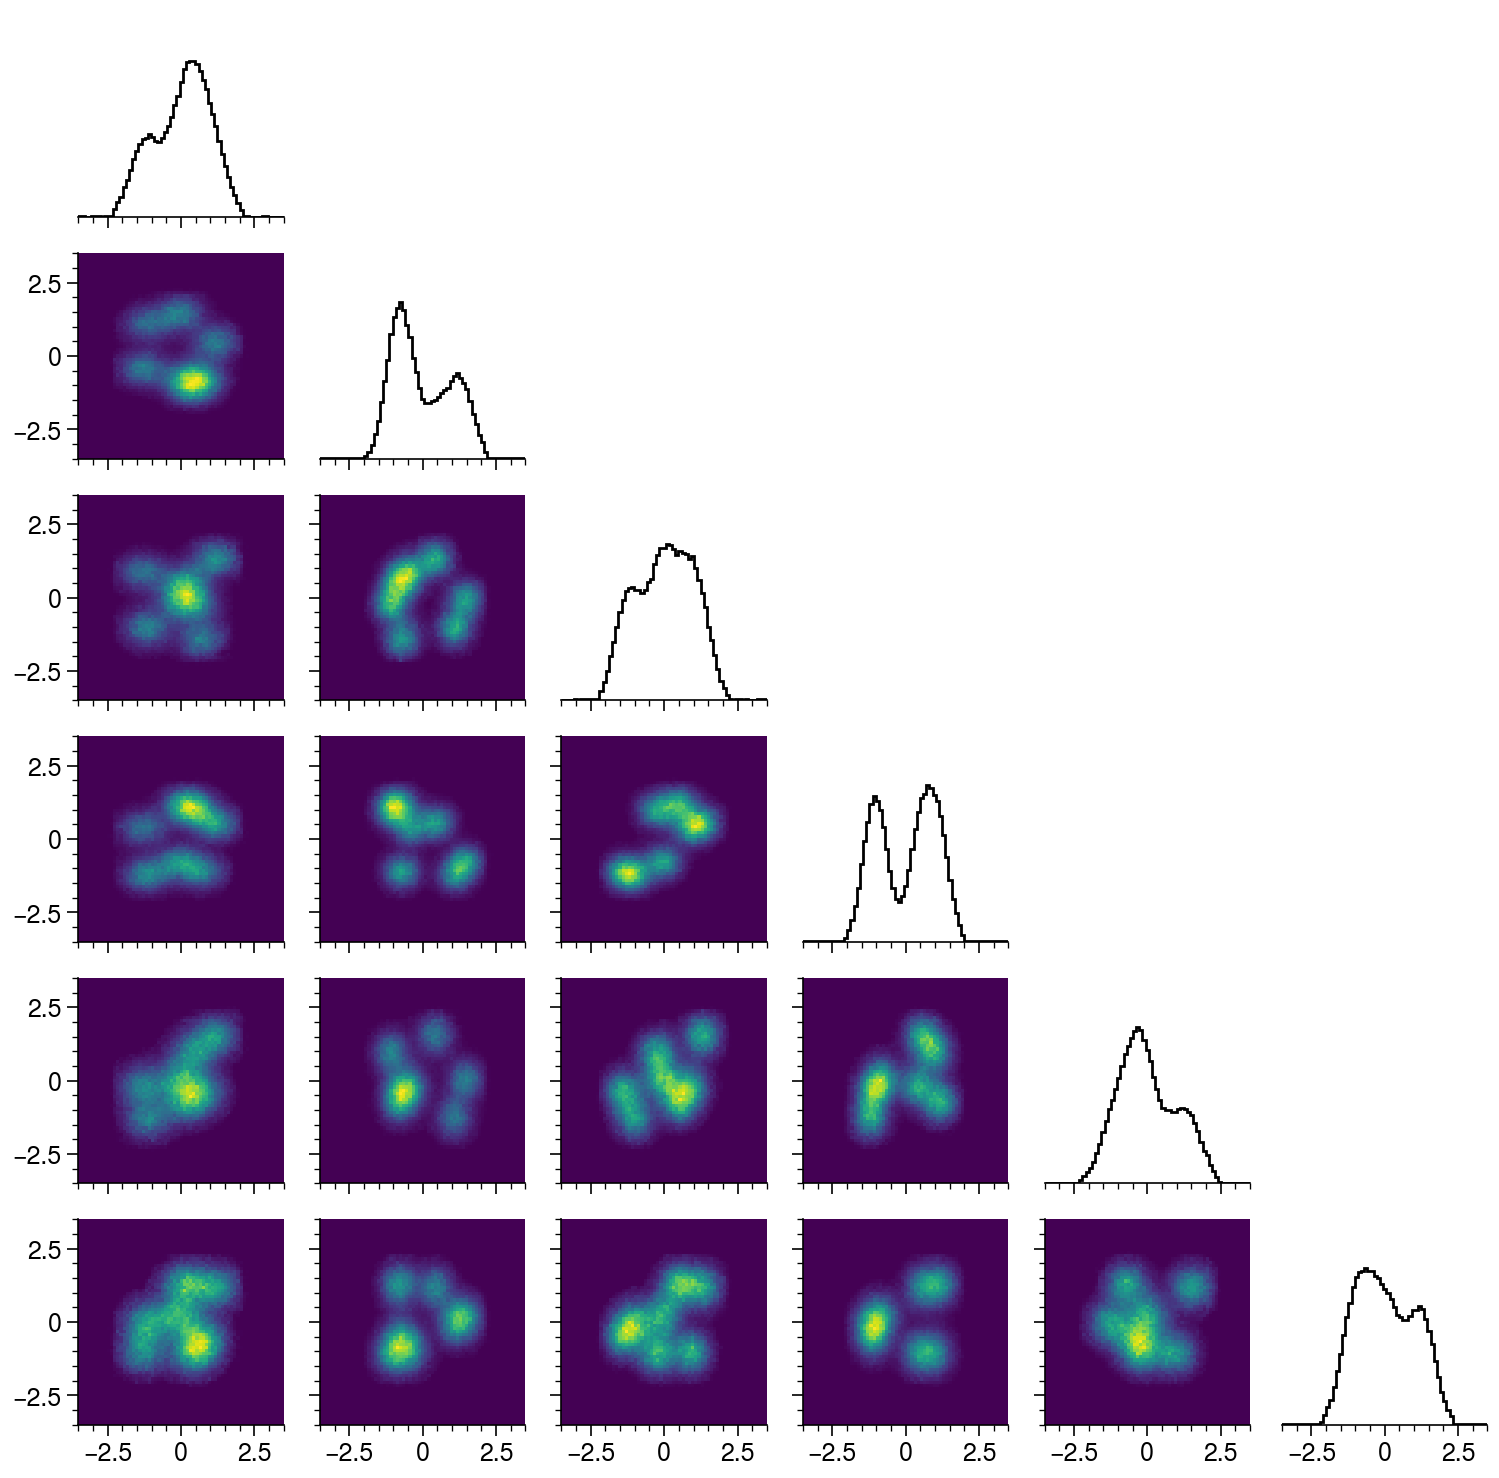

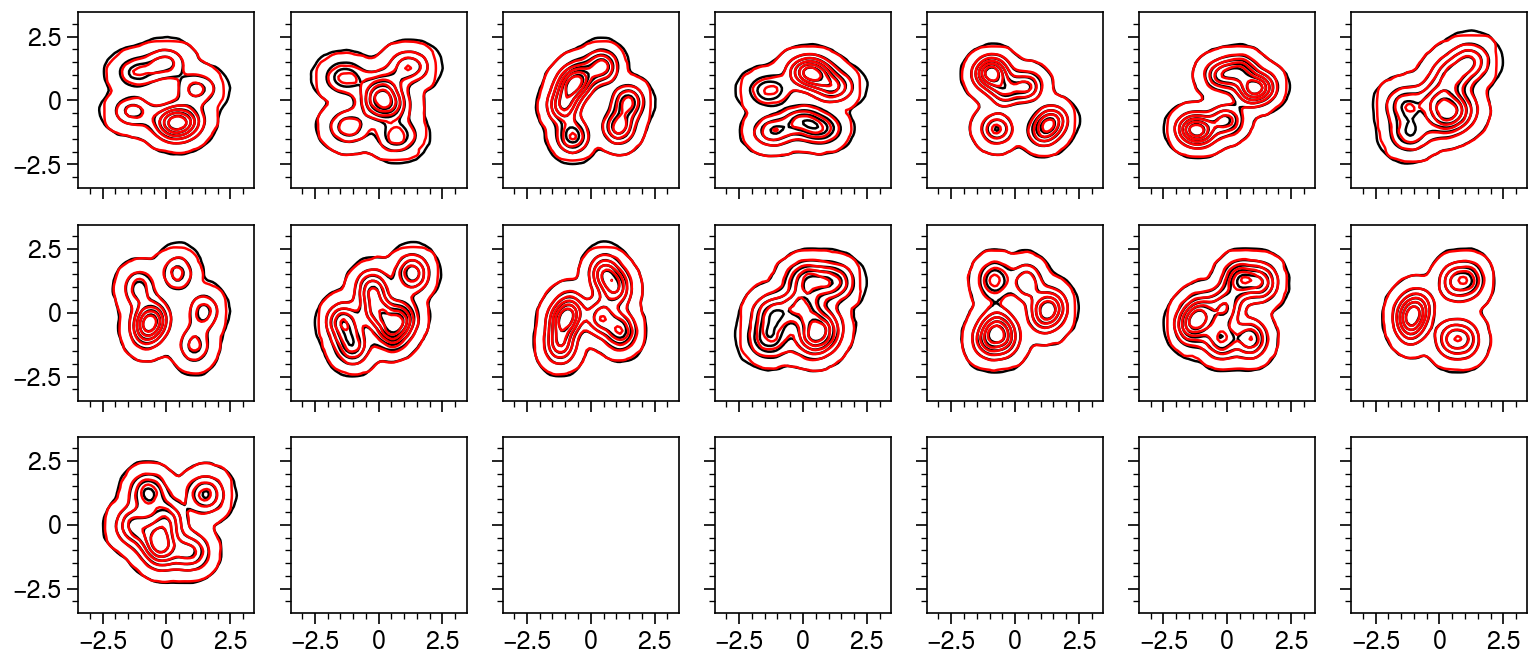

None


In [13]:
trainer = ment.train.Trainer(
    model,
    plot_func=plot_model,
    eval_func=None,
    notebook=True,
)
trainer.train(
    epochs=3,
    learning_rate=0.80,
)

## Evaluate

  0%|                                                                                                                                                                            | 0/1499 [00:00<?, ?it/s]

  4%|██████▋                                                                                                                                                           | 62/1499 [00:00<00:02, 613.35it/s]

  8%|█████████████▎                                                                                                                                                   | 124/1499 [00:00<00:02, 610.36it/s]

 12%|████████████████████                                                                                                                                             | 187/1499 [00:00<00:02, 617.20it/s]

 17%|██████████████████████████▋                                                                                                                                      | 249/1499 [00:00<00:02, 618.12it/s]

 21%|█████████████████████████████████▍                                                                                                                               | 311/1499 [00:00<00:01, 617.24it/s]

 25%|████████████████████████████████████████                                                                                                                         | 373/1499 [00:00<00:01, 613.63it/s]

 29%|██████████████████████████████████████████████▋                                                                                                                  | 435/1499 [00:00<00:01, 614.79it/s]

 33%|█████████████████████████████████████████████████████▍                                                                                                           | 497/1499 [00:00<00:01, 613.92it/s]

 37%|████████████████████████████████████████████████████████████▎                                                                                                    | 562/1499 [00:00<00:01, 624.82it/s]

 42%|███████████████████████████████████████████████████████████████████▏                                                                                             | 625/1499 [00:01<00:01, 621.69it/s]

 46%|█████████████████████████████████████████████████████████████████████████▉                                                                                       | 688/1499 [00:01<00:01, 623.46it/s]

 50%|████████████████████████████████████████████████████████████████████████████████▋                                                                                | 751/1499 [00:01<00:01, 623.61it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 814/1499 [00:01<00:01, 623.08it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 877/1499 [00:01<00:01, 621.89it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 940/1499 [00:01<00:00, 619.58it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1004/1499 [00:01<00:00, 623.14it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1068/1499 [00:01<00:00, 626.60it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1134/1499 [00:01<00:00, 634.03it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1200/1499 [00:01<00:00, 639.88it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1265/1499 [00:02<00:00, 641.04it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1331/1499 [00:02<00:00, 644.23it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1396/1499 [00:02<00:00, 643.28it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1461/1499 [00:02<00:00, 635.36it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 626.03it/s]

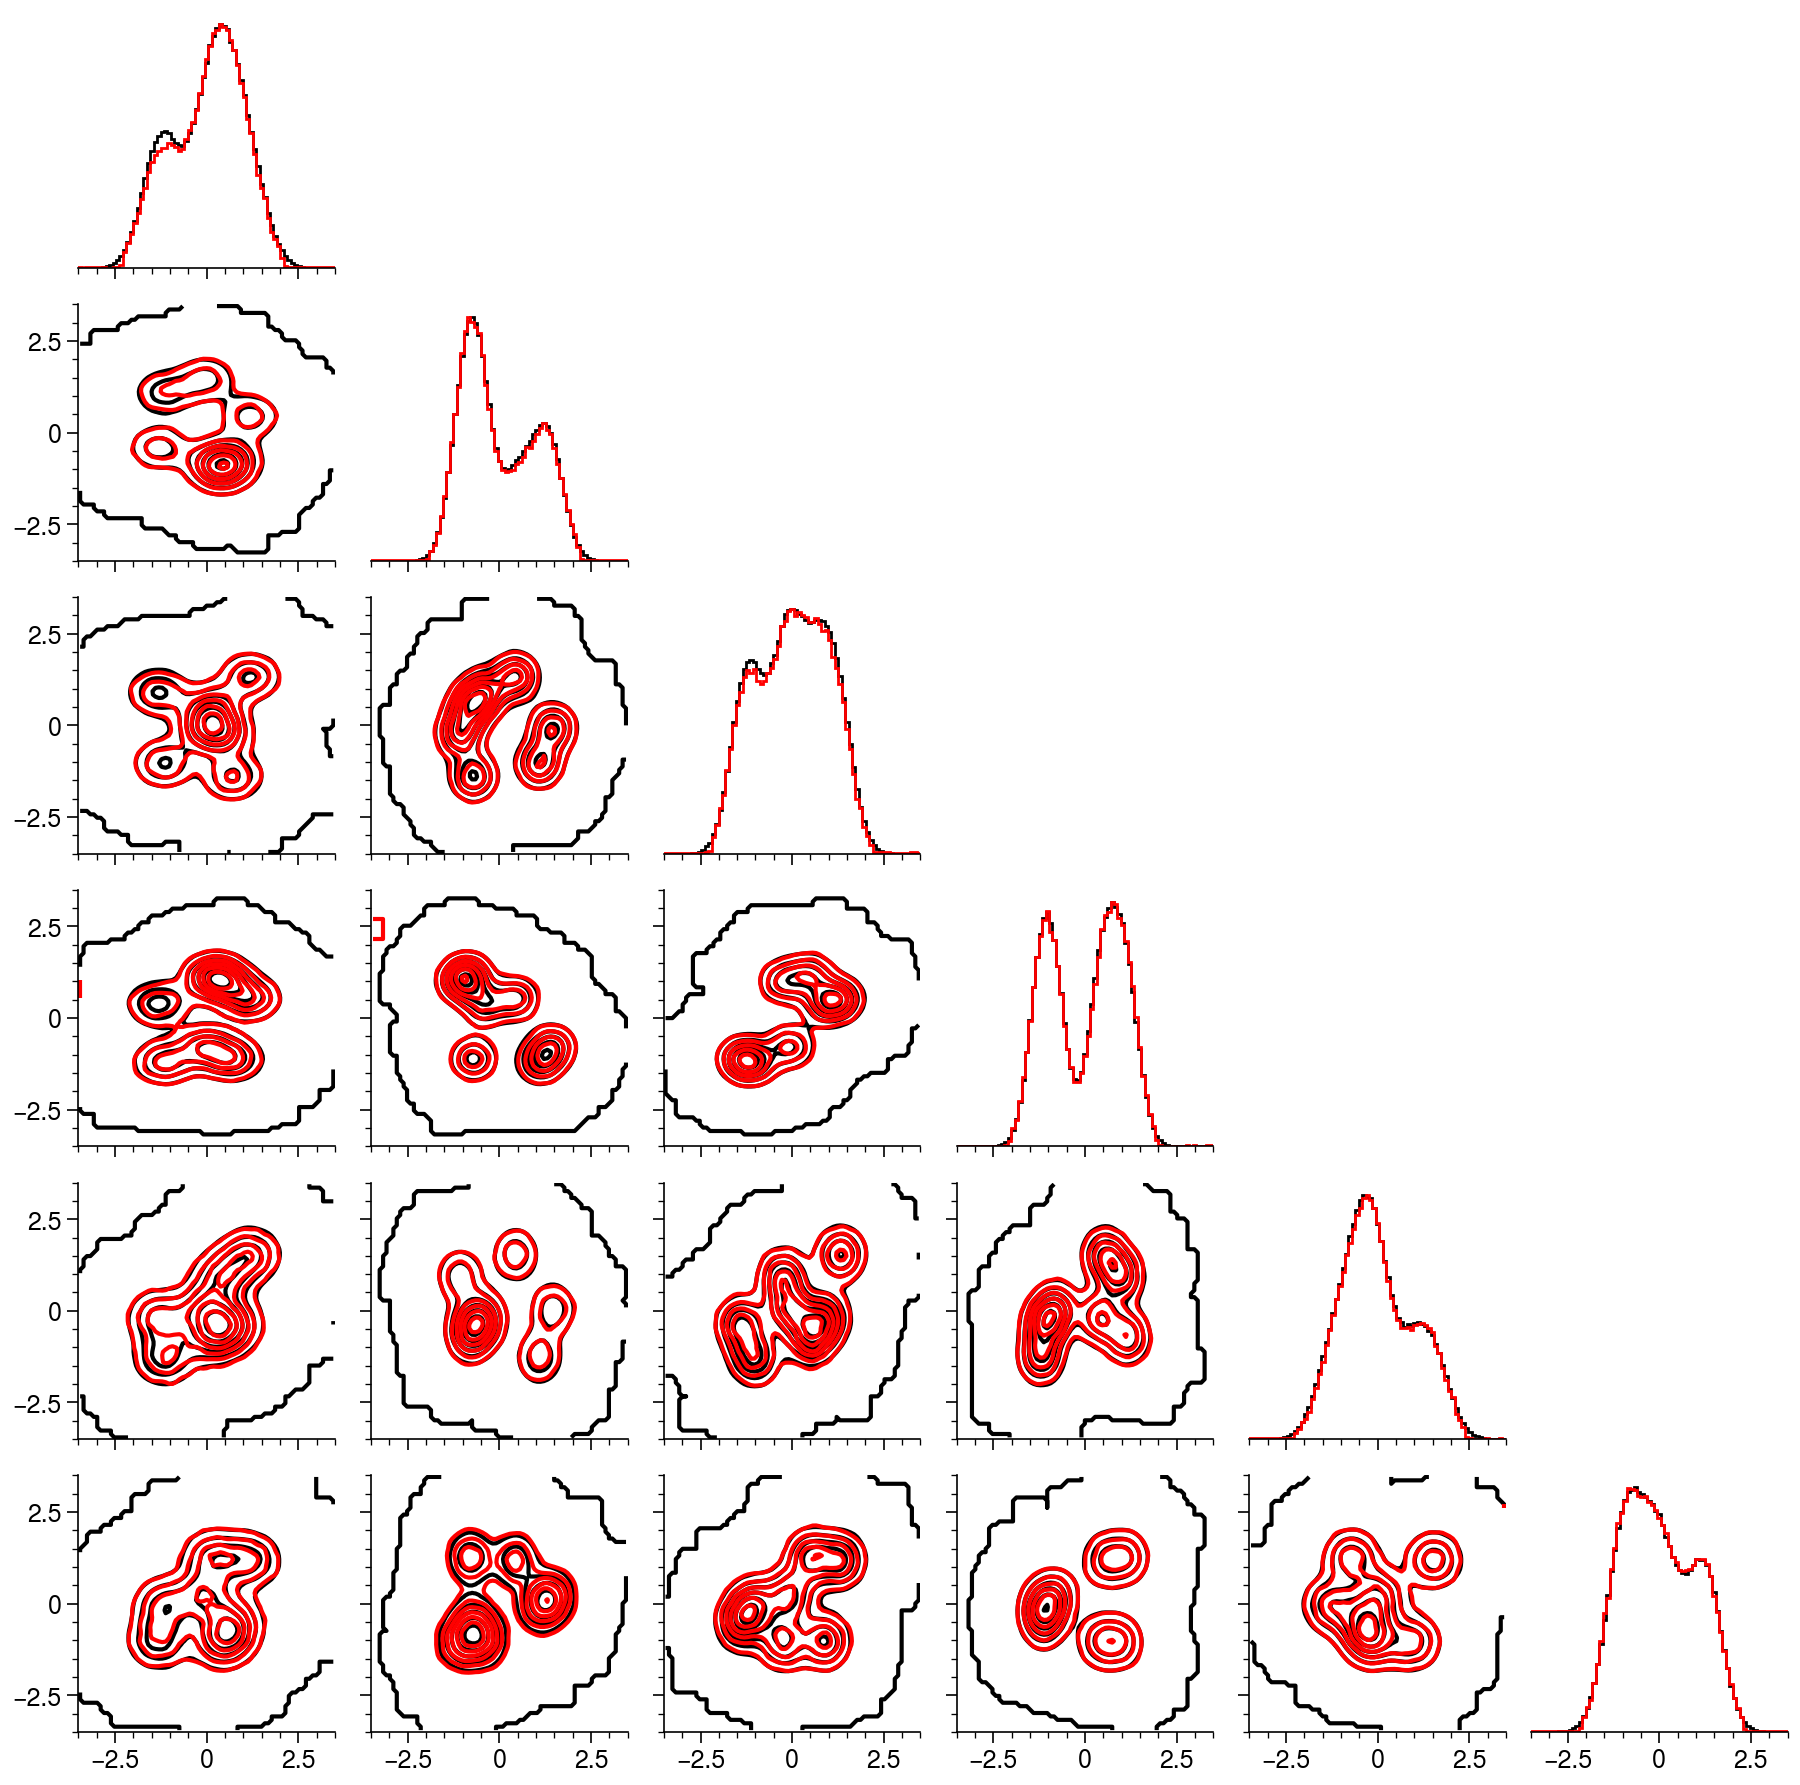

In [14]:
x_pred = model.unnormalize(model.sample(1_000_000))

grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.5))
for x, color in zip([x_true, x_pred], ["black", "red"]):
    grid.plot(
        x,
        limits=limits,
        bins=75,
        diag_kws=dict(color=color),
        mask=False,
        kind="contour",
        process_kws=dict(blur=1.0),
        color=color,
        N=7,
    )
plt.show()